## Stock Screener: Model Training and Evaluation

### Library Installation (if needed)

In [1]:
# Install libraries the first time
# ! conda install fastai::fastai conda-forge::yfinance pandas pathlib numpy

### Importing Required Libraries

In [2]:
from fastai.tabular.all import *
from fastai.metrics import rmse, mae
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import pathlib

### Variables

In [3]:
# Model settings
modelName = 'stockScreenerV1.6'
trainingData = 'stockData.csv'
getNewData = True 
trainNewModel = True
predictionTarget = 'DRS'  # 'ALL' for all, 'amount%', 'None' for no prediction

# Training parameters
trainingSize = 1000  # Number of stocks to use for training
timeFrame = '10y'   # Options: '1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max'
yNames = ['Future Year Change']
contNames = [
    'Open', 'Close', 'Volume', 'Dividends', 'Stock Splits',
    'EV/EBIT', 'ROIC']
catNames = ['Industry']
batchSize = 256
epochs = 25

# Testing parameters
testSize = 200  # Number of stocks to test, 'ALL' for all non-training stocks

# Paths
basePath = Path.cwd().parent
dataFolder = basePath / 'TrainingData'
modelFolder = basePath.parent / 'TrainedModels' / 'stockScreener'
testFolder = basePath / 'TestData'

## Data Preparation

#### Functions

In [4]:
def calculateFutureYearChange(ticker_symbol, timeframe, buffer=1):
    try:
        ticker = yf.Ticker(ticker_symbol)
        end_date = datetime.now().date()
        
        # Calculate required date range
        if timeframe == 'max':
            hist = ticker.history(period='max')
        else:
            years = int(timeframe[:-1])
            start_date = end_date - pd.DateOffset(years=years + buffer)
            
            # First check if ticker has existed long enough
            try:
                hist = ticker.history(start=start_date, end=end_date)
            except Exception as e:
                print(f"Data unavailable for {ticker_symbol} ({timeframe}): {e}")
                return pd.DataFrame()

        if hist.empty:
            print(f"No data found for {ticker_symbol} ({timeframe})")
            return pd.DataFrame()

        # Calculate future changes only if we have enough data points
        if len(hist) < 300:  # Minimum ~1.5 years of trading days
            print(f"Insufficient data for {ticker_symbol} ({len(hist)} rows)")
            return pd.DataFrame()

        # Calculate future price change
        hist['Future Year Change'] = (hist['Close'].shift(-252) / hist['Close'] - 1)
        hist = hist.dropna(subset=['Future Year Change'])
        
        return hist[['Open', 'Close', 'Volume', 'Dividends', 'Stock Splits', 
            'Future Year Change']].reset_index()

    except Exception as e:
        print(f"Error processing {ticker_symbol}: {str(e)}")
        return pd.DataFrame()

In [5]:
def calculateApproxEBIT(tickerSymbol):
    try:
        info = yf.Ticker(tickerSymbol).info
        revenue = info.get('totalRevenue', None)
        operatingIncome = info.get('operatingIncome', None)
        ebit = operatingIncome if operatingIncome else (revenue * 0.15 if revenue else None)
        return ebit if ebit and ebit != 0 else None  # Avoid zero division
    except Exception as e:
        return None

In [6]:
def enrichDataWithMetrics(histData):
    """Adds EV/EBIT and ROIC to the historical data."""
    # Initialize columns with NaN if they don't exist
    if 'EV/EBIT' not in histData.columns:
        histData['EV/EBIT'] = np.nan
    if 'ROIC' not in histData.columns:
        histData['ROIC'] = np.nan
    
    for ticker in histData['Ticker'].unique():
        try:
            evInfo = yf.Ticker(ticker).info
            totalDebt, cash, sharesOutstanding = evInfo.get('totalDebt', 0), evInfo.get('totalCash', 0), evInfo.get('sharesOutstanding', None)
            ebit = calculateApproxEBIT(ticker)

            if sharesOutstanding and ebit and ebit != 0:
                histData.loc[histData['Ticker'] == ticker, 'EV/EBIT'] = (
                    (histData['Close'] * sharesOutstanding + totalDebt - cash) / ebit
                )

                taxRate = 0.21
                nopat = ebit * (1 - taxRate)
                investedCapital = totalDebt + (histData['Close'] * sharesOutstanding) - cash
                histData.loc[histData['Ticker'] == ticker, 'ROIC'] = nopat / investedCapital
        except Exception as e:
            pass
    return histData

In [7]:
def getTickerDataFrom1YrAgo(ticker_symbol):
    try:
        # Fetch ticker data
        ticker = yf.Ticker(ticker_symbol)

        # Define the date range: one year ago to today
        today = datetime.today()
        one_year_ago = today - timedelta(days=365)

        # Fetch historical data for one year ago
        hist = ticker.history(start=(one_year_ago - timedelta(days=30)).strftime('%Y-%m-%d'), 
                              end=(one_year_ago + timedelta(days=0)).strftime('%Y-%m-%d'))
        if hist.empty:
            raise ValueError(f"No historical data available for {ticker_symbol} around {one_year_ago.strftime('%Y-%m-%d')}.")

        # Extract the closest data point to one year ago
        row = hist.iloc[0]  # Get the first available entry within the date range

        # Price today
        price_today = ticker.history(period='1d')['Close'].iloc[-1]

        # Calculate future price change (from one year ago to today)
        price_change_future = ((price_today - row['Close']) / row['Close']) if row['Close'] else None

        # Collect additional data
        evInfo = yf.Ticker(ticker_symbol).info
        total_debt, cash, shares_outstanding = evInfo.get('totalDebt', 0), evInfo.get('totalCash', 0), evInfo.get('sharesOutstanding', None)
        ebit = calculateApproxEBIT(ticker_symbol)
        ev = (row['Close'] * shares_outstanding) + total_debt - cash if shares_outstanding else None
        ev_ebit = ev / ebit if ebit else None
        market_cap = row['Close'] * shares_outstanding if shares_outstanding else None
        tax_rate = 0.21
        nopat = ebit * (1 - tax_rate) if ebit else None
        invested_capital = total_debt + market_cap - cash if market_cap and total_debt and cash else None
        roic = nopat / invested_capital if nopat and invested_capital else None
        industry = yf.Ticker(ticker_symbol).info.get('industry', 'Unknown')

        # Return as a DataFrame
        return pd.DataFrame([{
            'Ticker': ticker_symbol,
            'Date': row.name,
            'Open': row['Open'],
            'High': row['High'],
            'Low': row['Low'],
            'Close': row['Close'],
            'Volume': row['Volume'],
            'Dividends': row.get('Dividends', 0.0),
            'Stock Splits': row.get('Stock Splits', 0.0),
            'Future Year Change': price_change_future,
            'Industry': industry,
            'EV/EBIT': ev_ebit,
            'ROIC': roic
        }])

    except Exception as e:
        print(f"Error fetching data for {ticker_symbol}: {e}")
        return pd.DataFrame()

In [8]:
def getTickerData(ticker_symbol):
    try:
        ticker = yf.Ticker(ticker_symbol)
        hist = ticker.history(period='1d')
        evInfo = ticker.info
        total_debt, cash, shares_outstanding = evInfo.get('totalDebt', 0), evInfo.get('totalCash', 0), evInfo.get('sharesOutstanding', None)
        ebit = calculateApproxEBIT(ticker_symbol)
        ev = (hist['Close'].iloc[-1] * shares_outstanding) + total_debt - cash
        ev_ebit = ev / ebit if ebit else None
        market_cap = hist['Close'].iloc[-1] * shares_outstanding
        tax_rate = 0.21
        nopat = ebit * (1 - tax_rate) if ebit else None
        invested_capital = total_debt + market_cap - cash
        roic = nopat / invested_capital if nopat and invested_capital else None
        industry = yf.Ticker(ticker_symbol).info.get('industry', 'Unknown')
        
        # Add the 'Date' column
        date = datetime.now().strftime('%Y-%m-%d')

        return pd.DataFrame([{
            'Date': date,
            'Open': hist['Open'].iloc[-1],
            'High': hist['High'].iloc[-1],
            'Low': hist['Low'].iloc[-1],
            'Close': hist['Close'].iloc[-1],
            'Volume': hist['Volume'].iloc[-1],
            'Dividends': hist.get('Dividends', pd.Series([0.0])).iloc[-1],
            'Stock Splits': hist.get('Stock Splits', pd.Series([0.0])).iloc[-1],
            'EV/EBIT': ev_ebit,
            'Market Cap': market_cap,
            'ROIC': roic,
            'Industry': industry
        }])
    except Exception:
        return pd.DataFrame()

#### Download and Process Historical Data

In [9]:
tickers = pd.read_csv(testFolder / 'tickers.csv')['Ticker']
trainingTickers = np.random.choice(tickers, size=trainingSize, replace=False)

if getNewData:
    histData = pd.DataFrame()
    valid_tickers = []
    
    for ticker in trainingTickers:
        print(f"Processing {ticker}...")
        data = calculateFutureYearChange(ticker, timeFrame)
        if not data.empty:
            data['Ticker'] = ticker
            data['Industry'] = yf.Ticker(ticker).info.get('industry', 'Unknown')
            data['Date'] = pd.to_datetime(data['Date']).dt.tz_localize(None)
            
            # Enrich individual ticker data first
            ticker_data = enrichDataWithMetrics(data)
            histData = pd.concat([histData, ticker_data])
            
            # Check if metrics were added
            if 'ROIC' not in ticker_data.columns:
                print(f"WARNING: Failed to add metrics for {ticker}")
            
            valid_tickers.append(ticker)
        else:
            print(f"Skipped {ticker} - insufficient data")

    print(f"\nColumns in final dataset: {histData.columns.tolist()}")
    
    if not histData.empty:
        histData = enrichDataWithMetrics(histData)
        histData.to_csv(dataFolder / trainingData, index=True)
        # Verify no future targets leaked to past dates
        latest_date = pd.to_datetime(histData['Date']).max()
        if 'Future Year Change' in histData.columns:
            target_dates = histData[histData['Future Year Change'].notnull()]['Date']
            if any(pd.to_datetime(target_dates) > latest_date):
                raise ValueError("CRITICAL: Analyst targets contain future dates!")
        print(f"Saved training data with {len(histData)} rows")
    else:
        print("Warning: No data collected - check your tickers list")

Processing EGP...
Processing ARWR...
Processing OFC-L...


$OFC-L: possibly delisted; no timezone found


No data found for OFC-L (10y)
Skipped OFC-L - insufficient data
Processing TBBK...
Processing SRI...
Processing MGM...
Processing AMX...


$ENL: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing ENL...
No data found for ENL (10y)
Skipped ENL - insufficient data
Processing APA-D...


$APA-D: possibly delisted; no timezone found


No data found for APA-D (10y)
Skipped APA-D - insufficient data
Processing HUM...


$WAC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing WAC...
No data found for WAC (10y)
Skipped WAC - insufficient data
Processing ATTU...


$ATTU: possibly delisted; no timezone found
$CBMX: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for ATTU (10y)
Skipped ATTU - insufficient data
Processing CBMX...
No data found for CBMX (10y)
Skipped CBMX - insufficient data
Processing BICK...
Processing CIT...


$CIT: possibly delisted; no timezone found


No data found for CIT (10y)
Skipped CIT - insufficient data
Processing ANDAW...


$ANDAW: possibly delisted; no timezone found


No data found for ANDAW (10y)
Skipped ANDAW - insufficient data
Processing BUI...
Processing SRE...
Processing KCLI...
Processing SPTN...
Processing BELFB...
Processing ISNS...


$ISNS: possibly delisted; no timezone found


No data found for ISNS (10y)
Skipped ISNS - insufficient data
Processing BRKS...


$BRKS: possibly delisted; no timezone found


No data found for BRKS (10y)
Skipped BRKS - insufficient data
Processing ALL...
Processing GULF...
Processing PL-E...


$PL-E: possibly delisted; no timezone found


No data found for PL-E (10y)
Skipped PL-E - insufficient data
Processing PYS...


$LGF: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing LGF...
No data found for LGF (10y)
Skipped LGF - insufficient data
Processing AGC...


$AGC: possibly delisted; no timezone found


No data found for AGC (10y)
Skipped AGC - insufficient data
Processing YORW...
Processing BLIN...


$ANCI: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing ANCI...
No data found for ANCI (10y)
Skipped ANCI - insufficient data
Processing CWH...
Processing MHNA...


$MHNA: possibly delisted; no timezone found


No data found for MHNA (10y)
Skipped MHNA - insufficient data
Processing BERY...
Processing MNR-A...


$MNR-A: possibly delisted; no timezone found


No data found for MNR-A (10y)
Skipped MNR-A - insufficient data
Processing LVNTB...
Processing AFW...


$AFW: possibly delisted; no timezone found


No data found for AFW (10y)
Skipped AFW - insufficient data
Processing EIX...
Processing HSC...


$HSC: possibly delisted; no timezone found


No data found for HSC (10y)
Skipped HSC - insufficient data
Processing CBPO...


$CBPO: possibly delisted; no timezone found
$YOKU: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for CBPO (10y)
Skipped CBPO - insufficient data
Processing YOKU...
No data found for YOKU (10y)
Skipped YOKU - insufficient data
Processing PRGO...
Processing MNDO...
Processing CBM...


$CBM: possibly delisted; no timezone found


No data found for CBM (10y)
Skipped CBM - insufficient data
Processing COCO...
Processing BTH...
Insufficient data for BTH (1 rows)
Skipped BTH - insufficient data
Processing SBBX...


$SBBX: possibly delisted; no timezone found
$IILG: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)
$LONG: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for SBBX (10y)
Skipped SBBX - insufficient data
Processing IILG...
No data found for IILG (10y)
Skipped IILG - insufficient data
Processing LONG...
No data found for LONG (10y)
Skipped LONG - insufficient data
Processing TECD...


$TECD: possibly delisted; no timezone found


No data found for TECD (10y)
Skipped TECD - insufficient data
Processing TRNO...
Processing ESCA...


$GNVC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing GNVC...
No data found for GNVC (10y)
Skipped GNVC - insufficient data
Processing PSCD...
Processing WASH...


$PVTB: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing PVTB...
No data found for PVTB (10y)
Skipped PVTB - insufficient data
Processing NEON...


$BOFI: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing BOFI...
No data found for BOFI (10y)
Skipped BOFI - insufficient data
Processing MSJ...


$MSJ: possibly delisted; no timezone found


No data found for MSJ (10y)
Skipped MSJ - insufficient data
Processing CACGW...


$CACGW: possibly delisted; no timezone found
$PENX: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for CACGW (10y)
Skipped CACGW - insufficient data
Processing PENX...
No data found for PENX (10y)
Skipped PENX - insufficient data
Processing LEDS...
Processing MOH...
Processing MPG-A...


$MPG-A: possibly delisted; no timezone found


No data found for MPG-A (10y)
Skipped MPG-A - insufficient data
Processing CSFL...


$CSFL: possibly delisted; no timezone found


No data found for CSFL (10y)
Skipped CSFL - insufficient data
Processing GBNK...
Processing VITC...


$VITC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for VITC (10y)
Skipped VITC - insufficient data
Processing EGN...


$FUBC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing FUBC...
No data found for FUBC (10y)
Skipped FUBC - insufficient data
Processing FISI...
Processing CRT...
Processing RBS-I...


$RBS-I: possibly delisted; no timezone found


No data found for RBS-I (10y)
Skipped RBS-I - insufficient data
Processing PLCE...
Processing PRA...
Processing AGIO...
Processing WAB...
Processing RDN...
Processing TRS...
Processing NRF-A...


$NRF-A: possibly delisted; no timezone found


No data found for NRF-A (10y)
Skipped NRF-A - insufficient data
Processing NTL...


$HCN: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing HCN...
No data found for HCN (10y)
Skipped HCN - insufficient data
Processing KSS...


$CMSB: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing CMSB...
No data found for CMSB (10y)
Skipped CMSB - insufficient data
Processing JQC...
Processing GPM...


$GPM: possibly delisted; no timezone found


No data found for GPM (10y)
Skipped GPM - insufficient data
Processing CCMP...


$CCMP: possibly delisted; no timezone found
$UNTK: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for CCMP (10y)
Skipped CCMP - insufficient data
Processing UNTK...
No data found for UNTK (10y)
Skipped UNTK - insufficient data
Processing CTIB...


$CTIB: possibly delisted; no timezone found


No data found for CTIB (10y)
Skipped CTIB - insufficient data
Processing IDRA...


$IDRA: possibly delisted; no timezone found
$STRZA: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for IDRA (10y)
Skipped IDRA - insufficient data
Processing STRZA...
No data found for STRZA (10y)
Skipped STRZA - insufficient data
Processing CPRT...
Processing MSZ...


$MSZ: possibly delisted; no timezone found
$KKD: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)
$GAT: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for MSZ (10y)
Skipped MSZ - insufficient data
Processing KKD...
No data found for KKD (10y)
Skipped KKD - insufficient data
Processing GAT...
No data found for GAT (10y)
Skipped GAT - insufficient data
Processing HCIIP...
Processing MVCB...


$MVCB: possibly delisted; no timezone found


No data found for MVCB (10y)
Skipped MVCB - insufficient data
Processing MXF...
Processing ALIM...


$ALIM: possibly delisted; no timezone found


No data found for ALIM (10y)
Skipped ALIM - insufficient data
Processing LRCX...
Processing MOD...


$ANN: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)
$RTK: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing ANN...
No data found for ANN (10y)
Skipped ANN - insufficient data
Processing RTK...
No data found for RTK (10y)
Skipped RTK - insufficient data
Processing FBMI...


$FBMI: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)
$AEPI: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for FBMI (10y)
Skipped FBMI - insufficient data
Processing AEPI...
No data found for AEPI (10y)
Skipped AEPI - insufficient data
Processing PSTI...


$PSTI: possibly delisted; no timezone found


No data found for PSTI (10y)
Skipped PSTI - insufficient data
Processing NCLH...
Processing FOX...


$RLOC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing RLOC...
No data found for RLOC (10y)
Skipped RLOC - insufficient data
Processing FRC-C...


$FRC-C: possibly delisted; no timezone found
$MHR: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for FRC-C (10y)
Skipped FRC-C - insufficient data
Processing MHR...
No data found for MHR (10y)
Skipped MHR - insufficient data
Processing SFUN...


$SFUN: possibly delisted; no timezone found


No data found for SFUN (10y)
Skipped SFUN - insufficient data
Processing CWBC...
Processing CWHO...


$CWHO: possibly delisted; no timezone found


No data found for CWHO (10y)
Skipped CWHO - insufficient data
Processing DDC...
Insufficient data for DDC (295 rows)
Skipped DDC - insufficient data
Processing BTF...
Processing IIJI...


$IIJI: possibly delisted; no timezone found


No data found for IIJI (10y)
Skipped IIJI - insufficient data
Processing GALTW...


$GALTW: possibly delisted; no timezone found


No data found for GALTW (10y)
Skipped GALTW - insufficient data
Processing TPC...
Processing NED...


$NED: possibly delisted; no timezone found


No data found for NED (10y)
Skipped NED - insufficient data
Processing IT...
Processing PSEC...


$MPET: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing MPET...
No data found for MPET (10y)
Skipped MPET - insufficient data
Processing ELGX...


$ELGX: possibly delisted; no timezone found


No data found for ELGX (10y)
Skipped ELGX - insufficient data
Processing EHTH...
Processing SMIT...


$ESC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing ESC...
No data found for ESC (10y)
Skipped ESC - insufficient data
Processing CASM...


$CASM: possibly delisted; no timezone found


No data found for CASM (10y)
Skipped CASM - insufficient data
Processing OCN...


$OCN: possibly delisted; no timezone found


No data found for OCN (10y)
Skipped OCN - insufficient data
Processing I-A...


$I-A: possibly delisted; no timezone found
$IFT: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for I-A (10y)
Skipped I-A - insufficient data
Processing IFT...
No data found for IFT (10y)
Skipped IFT - insufficient data
Processing NCS...


$NCS: possibly delisted; no timezone found
$TZF: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for NCS (10y)
Skipped NCS - insufficient data
Processing TZF...
No data found for TZF (10y)
Skipped TZF - insufficient data
Processing MCBK...


$JBJ: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing JBJ...
No data found for JBJ (10y)
Skipped JBJ - insufficient data
Processing AAT...
Processing LPL...
Processing AAWW...


$AAWW: possibly delisted; no timezone found


No data found for AAWW (10y)
Skipped AAWW - insufficient data
Processing MITT...


$MDAS: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing MDAS...
No data found for MDAS (10y)
Skipped MDAS - insufficient data
Processing ATEC...
Processing PRH...
Processing PMT...
Processing OSBCP...


$OSBCP: possibly delisted; no timezone found
$GGP: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for OSBCP (10y)
Skipped OSBCP - insufficient data
Processing GGP...
No data found for GGP (10y)
Skipped GGP - insufficient data
Processing EMF...
Processing MUI...


$XTXI: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing XTXI...
No data found for XTXI (10y)
Skipped XTXI - insufficient data
Processing RELL...
Processing NATR...
Processing RNST...
Processing IIM...
Processing FANG...


$SBY: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing SBY...
No data found for SBY (10y)
Skipped SBY - insufficient data
Processing TWI...
Processing SGYP...


$SGYP: possibly delisted; no timezone found


No data found for SGYP (10y)
Skipped SGYP - insufficient data
Processing TCPC...
Processing VTWO...
Processing CRL...
Processing PL-B...


$PL-B: possibly delisted; no timezone found
$NUTR: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for PL-B (10y)
Skipped PL-B - insufficient data
Processing NUTR...
No data found for NUTR (10y)
Skipped NUTR - insufficient data
Processing INPH...


$INPH: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for INPH (10y)
Skipped INPH - insufficient data
Processing GGG...
Processing USPH...
Processing TROVU...


$TROVU: possibly delisted; no timezone found


No data found for TROVU (10y)
Skipped TROVU - insufficient data
Processing MEN...


$MEN: possibly delisted; no timezone found


No data found for MEN (10y)
Skipped MEN - insufficient data
Processing OABC...
Insufficient data for OABC (220 rows)
Skipped OABC - insufficient data
Processing DRAD...


$DRAD: possibly delisted; no timezone found


No data found for DRAD (10y)
Skipped DRAD - insufficient data
Processing EFT...


$XFR: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing XFR...
No data found for XFR (10y)
Skipped XFR - insufficient data
Processing IND...
Processing WDFC...
Processing EML...


$MSCA: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing MSCA...
No data found for MSCA (10y)
Skipped MSCA - insufficient data
Processing EXPR...


$EXPR: possibly delisted; no timezone found


No data found for EXPR (10y)
Skipped EXPR - insufficient data
Processing ASTI...
Processing NXP...
Processing KIRK...
Processing NX...
Processing ESLT...


$PATR: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing PATR...
No data found for PATR (10y)
Skipped PATR - insufficient data
Processing OXM...
Processing NATH...
Processing IRDMZ...


$IRDMZ: possibly delisted; no timezone found


No data found for IRDMZ (10y)
Skipped IRDMZ - insufficient data
Processing AEM...
Processing CADX...
Insufficient data for CADX (37 rows)
Skipped CADX - insufficient data
Processing USB-H...


$USB-H: possibly delisted; no timezone found


No data found for USB-H (10y)
Skipped USB-H - insufficient data
Processing ESS...
Processing SLGN...
Processing MTDR...
Processing AXJS...
Processing GSOL...
Insufficient data for GSOL (267 rows)
Skipped GSOL - insufficient data
Processing ALG...
Processing MT...
Processing BHK...
Processing APB...
Processing RPT-D...


$RPT-D: possibly delisted; no timezone found


No data found for RPT-D (10y)
Skipped RPT-D - insufficient data
Processing FRC-B...


$FRC-B: possibly delisted; no timezone found


No data found for FRC-B (10y)
Skipped FRC-B - insufficient data
Processing CATM...


$CATM: possibly delisted; no timezone found


No data found for CATM (10y)
Skipped CATM - insufficient data
Processing SONC...
Processing ETY...
Processing HHC...


$HHC: possibly delisted; no timezone found


No data found for HHC (10y)
Skipped HHC - insufficient data
Processing AAN...


$AAN: possibly delisted; no timezone found


No data found for AAN (10y)
Skipped AAN - insufficient data
Processing XYL...
Processing OPHC...
Processing GGT...
Processing BMR...
Processing TCO...


$TCO: possibly delisted; no timezone found
$KIPO: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)
$DRU: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for TCO (10y)
Skipped TCO - insufficient data
Processing KIPO...
No data found for KIPO (10y)
Skipped KIPO - insufficient data
Processing DRU...
No data found for DRU (10y)
Skipped DRU - insufficient data
Processing SKS...
Processing CALI...
Processing MRLN...


$MRLN: possibly delisted; no timezone found


No data found for MRLN (10y)
Skipped MRLN - insufficient data
Processing HPP...
Processing PETM...
Insufficient data for PETM (1 rows)
Skipped PETM - insufficient data
Processing YOD...


$YOD: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for YOD (10y)
Skipped YOD - insufficient data
Processing GOODO...
Processing PLBC...
Processing NJR...
Processing SDT...


$SDT: possibly delisted; no timezone found


No data found for SDT (10y)
Skipped SDT - insufficient data
Processing MTB...
Processing PBI-A...


$PBI-A: possibly delisted; no timezone found


No data found for PBI-A (10y)
Skipped PBI-A - insufficient data
Processing MH-A...


$MH-A: possibly delisted; no timezone found


No data found for MH-A (10y)
Skipped MH-A - insufficient data
Processing SPIL...
Processing CXO...


$CXO: possibly delisted; no timezone found


No data found for CXO (10y)
Skipped CXO - insufficient data
Processing VTUS...


$VTUS: possibly delisted; no timezone found


No data found for VTUS (10y)
Skipped VTUS - insufficient data
Processing ACG...
Insufficient data for ACG (1 rows)
Skipped ACG - insufficient data
Processing ENJ...
Processing SIFY...
Processing ADBE...
Processing JBHT...
Processing TTC...
Processing VMBS...
Processing IBKC...


$IBKC: possibly delisted; no timezone found


No data found for IBKC (10y)
Skipped IBKC - insufficient data
Processing AQU...


$CRDC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing CRDC...
No data found for CRDC (10y)
Skipped CRDC - insufficient data
Processing LOGI...
Processing AMAP...


$LINTA: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)
$KRFT: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing LINTA...
No data found for LINTA (10y)
Skipped LINTA - insufficient data
Processing KRFT...
No data found for KRFT (10y)
Skipped KRFT - insufficient data
Processing LAZ...
Processing RNWK...


$RNWK: possibly delisted; no timezone found


No data found for RNWK (10y)
Skipped RNWK - insufficient data
Processing IRS...
Processing HNRG...
Processing CAP...


$CAP: possibly delisted; no timezone found


No data found for CAP (10y)
Skipped CAP - insufficient data
Processing TRCB...


$TRCB: possibly delisted; no timezone found


No data found for TRCB (10y)
Skipped TRCB - insufficient data
Processing RBS-M...


$RBS-M: possibly delisted; no timezone found
$JDSU: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for RBS-M (10y)
Skipped RBS-M - insufficient data
Processing JDSU...
No data found for JDSU (10y)
Skipped JDSU - insufficient data
Processing GFA...
Processing NTX...


$NTX: possibly delisted; no timezone found


No data found for NTX (10y)
Skipped NTX - insufficient data
Processing CYCC...
Processing PWOD...
Processing RRC...
Processing EMITF...
Processing LSCC...


$TXTR: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)
$BOTA: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing TXTR...
No data found for TXTR (10y)
Skipped TXTR - insufficient data
Processing BOTA...
No data found for BOTA (10y)
Skipped BOTA - insufficient data
Processing UNFI...


$ACAS: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing ACAS...
No data found for ACAS (10y)
Skipped ACAS - insufficient data
Processing SCU...


$SCU: possibly delisted; no timezone found


No data found for SCU (10y)
Skipped SCU - insufficient data
Processing PDEX...
Processing EXPE...


$PJS: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing PJS...
No data found for PJS (10y)
Skipped PJS - insufficient data
Processing GRO...
Insufficient data for GRO (38 rows)
Skipped GRO - insufficient data
Processing NBTB...
Processing BDGE...


$BDGE: possibly delisted; no timezone found


No data found for BDGE (10y)
Skipped BDGE - insufficient data
Processing NASB...
Processing JCOM...


$JCOM: possibly delisted; no timezone found


No data found for JCOM (10y)
Skipped JCOM - insufficient data
Processing TREX...
Processing FNSR...


$FNSR: possibly delisted; no timezone found


No data found for FNSR (10y)
Skipped FNSR - insufficient data
Processing ONTX...


$ONTX: possibly delisted; no timezone found
$GEF.B: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for ONTX (10y)
Skipped ONTX - insufficient data
Processing GEF.B...
No data found for GEF.B (10y)
Skipped GEF.B - insufficient data
Processing MET-B...


$MET-B: possibly delisted; no timezone found


No data found for MET-B (10y)
Skipped MET-B - insufficient data
Processing COA...
Insufficient data for COA (68 rows)
Skipped COA - insufficient data
Processing CBD...


$CBD: possibly delisted; no timezone found


No data found for CBD (10y)
Skipped CBD - insufficient data
Processing IGT...
Processing CHTR...


$WFBI: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing WFBI...
No data found for WFBI (10y)
Skipped WFBI - insufficient data
Processing NSM...
Processing SAFM...


$SAFM: possibly delisted; no timezone found


No data found for SAFM (10y)
Skipped SAFM - insufficient data
Processing G...
Processing GUT-A...


$GUT-A: possibly delisted; no timezone found


No data found for GUT-A (10y)
Skipped GUT-A - insufficient data
Processing TYY-C...


$TYY-C: possibly delisted; no timezone found


No data found for TYY-C (10y)
Skipped TYY-C - insufficient data
Processing RAIL...
Processing DTV...


$DTV: possibly delisted; no timezone found


No data found for DTV (10y)
Skipped DTV - insufficient data
Processing CYTXW...


$CYTXW: possibly delisted; no timezone found


No data found for CYTXW (10y)
Skipped CYTXW - insufficient data
Processing MRF...
Processing DD-A...


$DD-A: possibly delisted; no timezone found


No data found for DD-A (10y)
Skipped DD-A - insufficient data
Processing EPD...


$EDE: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing EDE...
No data found for EDE (10y)
Skipped EDE - insufficient data
Processing BTO...
Processing AXS...
Processing IPHI...


$IPHI: possibly delisted; no timezone found


No data found for IPHI (10y)
Skipped IPHI - insufficient data
Processing PRFT...


$PRFT: possibly delisted; no timezone found


No data found for PRFT (10y)
Skipped PRFT - insufficient data
Processing AHL...
Processing DOW...
Processing CGNX...
Processing STZ...
Processing HVT...
Processing USB...
Processing CHKP...
Processing EVR...
Processing SSNC...


$EDT: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing EDT...
No data found for EDT (10y)
Skipped EDT - insufficient data
Processing NAUH...


$RAX: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing RAX...
No data found for RAX (10y)
Skipped RAX - insufficient data
Processing MRC...
Processing CCNE...


$FCS: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing FCS...
No data found for FCS (10y)
Skipped FCS - insufficient data
Processing QGEN...
Processing STT-C...


$STT-C: possibly delisted; no timezone found
$FCZA: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for STT-C (10y)
Skipped STT-C - insufficient data
Processing FCZA...
No data found for FCZA (10y)
Skipped FCZA - insufficient data
Processing LECO...
Processing CPN...
Processing AIQ...
Processing CTRP...


$CTRP: possibly delisted; no timezone found
$JACQ: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for CTRP (10y)
Skipped CTRP - insufficient data
Processing JACQ...
No data found for JACQ (10y)
Skipped JACQ - insufficient data
Processing CHDN...
Processing PB...
Processing OKE...
Processing DFRG...


$DFRG: possibly delisted; no timezone found


No data found for DFRG (10y)
Skipped DFRG - insufficient data
Processing GFED...


$GFED: possibly delisted; no timezone found


No data found for GFED (10y)
Skipped GFED - insufficient data
Processing DNB...


$GIMO: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing GIMO...
No data found for GIMO (10y)
Skipped GIMO - insufficient data
Processing GILD...
Processing CP...
Processing GAIA...
Processing SIGM...


$SIGM: possibly delisted; no timezone found
$NBCB: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for SIGM (10y)
Skipped SIGM - insufficient data
Processing NBCB...
No data found for NBCB (10y)
Skipped NBCB - insufficient data
Processing CIF...
Processing NDLS...
Processing STAG...
Processing KYE...
Insufficient data for KYE (275 rows)
Skipped KYE - insufficient data
Processing IIN...


$IIN: possibly delisted; no timezone found


No data found for IIN (10y)
Skipped IIN - insufficient data
Processing UFI...
Processing PICO...


$PICO: possibly delisted; no timezone found


No data found for PICO (10y)
Skipped PICO - insufficient data
Processing UMPQ...


$UMPQ: possibly delisted; no timezone found


No data found for UMPQ (10y)
Skipped UMPQ - insufficient data
Processing AP...
Processing HAE...
Processing PFX...


$PQ: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing PQ...
No data found for PQ (10y)
Skipped PQ - insufficient data
Processing AFCB...
Processing AMRC...


$PRXI: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing PRXI...
No data found for PRXI (10y)
Skipped PRXI - insufficient data
Processing UNXL...


$UNXL: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)
$PZB: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for UNXL (10y)
Skipped UNXL - insufficient data
Processing PZB...
No data found for PZB (10y)
Skipped PZB - insufficient data
Processing OSUR...
Processing AKRX...


$AKRX: possibly delisted; no timezone found


No data found for AKRX (10y)
Skipped AKRX - insufficient data
Processing SKM...


$WRES: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing WRES...
No data found for WRES (10y)
Skipped WRES - insufficient data
Processing MEIP...
Processing SOHU...
Processing JCP...


$JCP: possibly delisted; no timezone found
$RDS.B: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)
$KBALB: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for JCP (10y)
Skipped JCP - insufficient data
Processing RDS.B...
No data found for RDS.B (10y)
Skipped RDS.B - insufficient data
Processing KBALB...
No data found for KBALB (10y)
Skipped KBALB - insufficient data
Processing CALD...
Processing ARTNA...
Processing SHIP...
Processing NRG...
Processing IQI...
Processing NAN...
Processing GRID...
Processing SPN...


$SPN: possibly delisted; no timezone found
$VSCP: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for SPN (10y)
Skipped SPN - insufficient data
Processing VSCP...
No data found for VSCP (10y)
Skipped VSCP - insufficient data
Processing ELRC...


$ELRC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for ELRC (10y)
Skipped ELRC - insufficient data
Processing ELSE...
Processing HIBB...


$HIBB: possibly delisted; no timezone found


No data found for HIBB (10y)
Skipped HIBB - insufficient data
Processing PBR...
Processing ARTW...
Processing FCEL...
Processing FCE.B...


$FCE.B: possibly delisted; no timezone found


No data found for FCE.B (10y)
Skipped FCE.B - insufficient data
Processing KTH...
Processing ARI...
Processing BSRR...
Processing TNC...
Processing FMX...


$LO: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing LO...
No data found for LO (10y)
Skipped LO - insufficient data
Processing WSTL...
Processing LQDT...
Processing WAL...
Processing HOG...


$BCR: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing BCR...
No data found for BCR (10y)
Skipped BCR - insufficient data
Processing AAON...
Processing ACIW...
Processing SEMG...


$SEMG: possibly delisted; no timezone found


No data found for SEMG (10y)
Skipped SEMG - insufficient data
Processing PEIX...


$PEIX: possibly delisted; no timezone found


No data found for PEIX (10y)
Skipped PEIX - insufficient data
Processing RENT...
Processing DGI...


$DGI: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for DGI (10y)
Skipped DGI - insufficient data
Processing GGM...
Processing LKFN...
Processing THRM...
Processing ACNB...
Processing NGX-C...


$NGX-C: possibly delisted; no timezone found


No data found for NGX-C (10y)
Skipped NGX-C - insufficient data
Processing CPSL...
Insufficient data for CPSL (95 rows)
Skipped CPSL - insufficient data
Processing CBST...


$CBST: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for CBST (10y)
Skipped CBST - insufficient data
Processing TLYS...
Processing HSII...
Processing SAFT...
Processing GILT...
Processing KMI...
Processing CHC.W...


$CHC.W: possibly delisted; no timezone found
$BAGL: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for CHC.W (10y)
Skipped CHC.W - insufficient data
Processing BAGL...
No data found for BAGL (10y)
Skipped BAGL - insufficient data
Processing AU-A...


$AU-A: possibly delisted; no timezone found


No data found for AU-A (10y)
Skipped AU-A - insufficient data
Processing ORN...
Processing RBS-F...


$RBS-F: possibly delisted; no timezone found


No data found for RBS-F (10y)
Skipped RBS-F - insufficient data
Processing TROX...
Processing ATLO...


$AIXG: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing AIXG...
No data found for AIXG (10y)
Skipped AIXG - insufficient data
Processing MHO...


$CLV: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing CLV...
No data found for CLV (10y)
Skipped CLV - insufficient data
Processing TEL...
Processing DRIV...
Processing PCAR...
Processing ORA...
Processing MKC...


$AYN: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing AYN...
No data found for AYN (10y)
Skipped AYN - insufficient data
Processing IHC...


$IHC: possibly delisted; no timezone found


No data found for IHC (10y)
Skipped IHC - insufficient data
Processing TAC...
Processing AQUUU...


$AQUUU: possibly delisted; no timezone found


No data found for AQUUU (10y)
Skipped AQUUU - insufficient data
Processing MFD...


$MFD: possibly delisted; no timezone found


No data found for MFD (10y)
Skipped MFD - insufficient data
Processing MOS...


$JFBI: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing JFBI...
No data found for JFBI (10y)
Skipped JFBI - insufficient data
Processing DWCH...
Processing BGS...
Processing NNC-D...


$NNC-D: possibly delisted; no timezone found


No data found for NNC-D (10y)
Skipped NNC-D - insufficient data
Processing IMPV...
Processing DAN...
Processing PRI...
Processing FHY...


$FHY: possibly delisted; no timezone found


No data found for FHY (10y)
Skipped FHY - insufficient data
Processing SYNA...
Processing COO...
Processing HQL...
Processing TCRD...


$TCRD: possibly delisted; no timezone found


No data found for TCRD (10y)
Skipped TCRD - insufficient data
Processing DV...
Processing MDT...
Processing PDCO...
Processing LUB...


$LUB: possibly delisted; no timezone found
$MBVT: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for LUB (10y)
Skipped LUB - insufficient data
Processing MBVT...
No data found for MBVT (10y)
Skipped MBVT - insufficient data
Processing PSCM...
Processing FCH-A...


$FCH-A: possibly delisted; no timezone found
$SWHC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for FCH-A (10y)
Skipped FCH-A - insufficient data
Processing SWHC...
No data found for SWHC (10y)
Skipped SWHC - insufficient data
Processing XPLR...
Processing IHG...
Processing RRD...


$RRD: possibly delisted; no timezone found


No data found for RRD (10y)
Skipped RRD - insufficient data
Processing PCRX...
Processing CVLT...
Processing SCHL...
Processing VAL...
Processing AIV-Z...


$AIV-Z: possibly delisted; no timezone found


No data found for AIV-Z (10y)
Skipped AIV-Z - insufficient data
Processing CVTI...


$CVTI: possibly delisted; no timezone found


No data found for CVTI (10y)
Skipped CVTI - insufficient data
Processing GES...
Processing DMRC...
Processing WEN...
Processing NOAH...
Processing SBGL...


$SBGL: possibly delisted; no timezone found


No data found for SBGL (10y)
Skipped SBGL - insufficient data
Processing YY...


$BIO.B: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)
CHXF: Period '1mo' is invalid, must be one of ['1d', '5d']


Processing BIO.B...
No data found for BIO.B (10y)
Skipped BIO.B - insufficient data
Processing CHXF...
No data found for CHXF (10y)
Skipped CHXF - insufficient data
Processing HAYN...


$HAYN: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26) (Yahoo error = "No data found, symbol may be delisted")


No data found for HAYN (10y)
Skipped HAYN - insufficient data
Processing ECOM...


$ECOM: possibly delisted; no timezone found


No data found for ECOM (10y)
Skipped ECOM - insufficient data
Processing RHP...
Processing MVT...
Processing CASH...
Processing EMEY...
Processing SHBI...
Processing QQXT...
Processing VRNT...
Processing VC...
Processing RFIL...


$CNBC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)
$BONT: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing CNBC...
No data found for CNBC (10y)
Skipped CNBC - insufficient data
Processing BONT...
No data found for BONT (10y)
Skipped BONT - insufficient data
Processing NQJ...


$NQJ: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for NQJ (10y)
Skipped NQJ - insufficient data
Processing MFNC...


$MFNC: possibly delisted; no timezone found


No data found for MFNC (10y)
Skipped MFNC - insufficient data
Processing PGI...
Processing BIOL...


$BIOL: possibly delisted; no timezone found


No data found for BIOL (10y)
Skipped BIOL - insufficient data
Processing DVN...


$AHT-PA: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing AHT-PA...
No data found for AHT-PA (10y)
Skipped AHT-PA - insufficient data
Processing FLWS...


$FEIC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)
$APPY: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing FEIC...
No data found for FEIC (10y)
Skipped FEIC - insufficient data
Processing APPY...
No data found for APPY (10y)
Skipped APPY - insufficient data
Processing BIG...


$BIG: possibly delisted; no timezone found


No data found for BIG (10y)
Skipped BIG - insufficient data
Processing IRM...
Processing LTM...
Insufficient data for LTM (126 rows)
Skipped LTM - insufficient data
Processing DGLY...
Processing NWS...
Processing AGNC...
Processing DPD...


$DPD: possibly delisted; no timezone found


No data found for DPD (10y)
Skipped DPD - insufficient data
Processing FIRE...
Processing AMCN...


$AMCN: possibly delisted; no timezone found


No data found for AMCN (10y)
Skipped AMCN - insufficient data
Processing XIN...
Processing GDL-B...


$GDL-B: possibly delisted; no timezone found
$ITMN: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for GDL-B (10y)
Skipped GDL-B - insufficient data
Processing ITMN...
No data found for ITMN (10y)
Skipped ITMN - insufficient data
Processing CBL-D...


$CBL-D: possibly delisted; no timezone found


No data found for CBL-D (10y)
Skipped CBL-D - insufficient data
Processing NPO...
Processing OPLK...
Insufficient data for OPLK (150 rows)
Skipped OPLK - insufficient data
Processing KMDA...
Processing RUSHA...
Processing MDLZ...
Processing NPTN...


$NPTN: possibly delisted; no timezone found
$ZLTQ: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for NPTN (10y)
Skipped NPTN - insufficient data
Processing ZLTQ...
No data found for ZLTQ (10y)
Skipped ZLTQ - insufficient data
Processing NYMTP...


$NYMTP: possibly delisted; no timezone found


No data found for NYMTP (10y)
Skipped NYMTP - insufficient data
Processing TRC...
Processing LTC...


$ACPW: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing ACPW...
No data found for ACPW (10y)
Skipped ACPW - insufficient data
Processing MPW...
Processing FFN...


$FFN: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for FFN (10y)
Skipped FFN - insufficient data
Processing CSS...


Failed to get ticker 'CSS' reason: Expecting value: line 1 column 1 (char 0)
$CSS: possibly delisted; no timezone found


No data found for CSS (10y)
Skipped CSS - insufficient data
Processing CORT...


$CORT: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for CORT (10y)
Skipped CORT - insufficient data
Processing PH...


Failed to get ticker 'PH' reason: Expecting value: line 1 column 1 (char 0)
$PH: possibly delisted; no timezone found


No data found for PH (10y)
Skipped PH - insufficient data
Processing NSYS...


$NSYS: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for NSYS (10y)
Skipped NSYS - insufficient data
Processing ACTG...


$ACTG: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for ACTG (10y)
Skipped ACTG - insufficient data
Processing DHX...


$DHX: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for DHX (10y)
Skipped DHX - insufficient data
Processing GPRC...


$GPRC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for GPRC (10y)
Skipped GPRC - insufficient data
Processing ETO...


$ETO: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for ETO (10y)
Skipped ETO - insufficient data
Processing EXL-B...


Failed to get ticker 'EXL-B' reason: Expecting value: line 1 column 1 (char 0)
$EXL-B: possibly delisted; no timezone found


No data found for EXL-B (10y)
Skipped EXL-B - insufficient data
Processing GS-C...


Failed to get ticker 'GS-C' reason: Expecting value: line 1 column 1 (char 0)
$GS-C: possibly delisted; no timezone found


No data found for GS-C (10y)
Skipped GS-C - insufficient data
Processing AN...


$AN: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for AN (10y)
Skipped AN - insufficient data
Processing TAYCO...


Failed to get ticker 'TAYCO' reason: Expecting value: line 1 column 1 (char 0)
$TAYCO: possibly delisted; no timezone found


No data found for TAYCO (10y)
Skipped TAYCO - insufficient data
Processing NGG...


$NGG: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for NGG (10y)
Skipped NGG - insufficient data
Processing PRAA...


$PRAA: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for PRAA (10y)
Skipped PRAA - insufficient data
Processing MGPI...


$MGPI: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for MGPI (10y)
Skipped MGPI - insufficient data
Processing IMOS...


Failed to get ticker 'IMOS' reason: Expecting value: line 1 column 1 (char 0)
$IMOS: possibly delisted; no timezone found


No data found for IMOS (10y)
Skipped IMOS - insufficient data
Processing CSC...


$CSC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for CSC (10y)
Skipped CSC - insufficient data
Processing ARG...


$ARG: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for ARG (10y)
Skipped ARG - insufficient data
Processing PPO...


$PPO: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for PPO (10y)
Skipped PPO - insufficient data
Processing KAP...


$KAP: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for KAP (10y)
Skipped KAP - insufficient data
Processing PVTBP...


$PVTBP: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for PVTBP (10y)
Skipped PVTBP - insufficient data
Processing SMF...


$SMF: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for SMF (10y)
Skipped SMF - insufficient data
Processing NZH-C...


Failed to get ticker 'NZH-C' reason: Expecting value: line 1 column 1 (char 0)
$NZH-C: possibly delisted; no timezone found


No data found for NZH-C (10y)
Skipped NZH-C - insufficient data
Processing FICO...


Failed to get ticker 'FICO' reason: Expecting value: line 1 column 1 (char 0)
$FICO: possibly delisted; no timezone found


No data found for FICO (10y)
Skipped FICO - insufficient data
Processing FULLL...


Failed to get ticker 'FULLL' reason: Expecting value: line 1 column 1 (char 0)
$FULLL: possibly delisted; no timezone found


No data found for FULLL (10y)
Skipped FULLL - insufficient data
Processing MHY...


$MHY: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for MHY (10y)
Skipped MHY - insufficient data
Processing ODFL...


$ODFL: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for ODFL (10y)
Skipped ODFL - insufficient data
Processing NS...


Failed to get ticker 'NS' reason: Expecting value: line 1 column 1 (char 0)
$NS: possibly delisted; no timezone found


No data found for NS (10y)
Skipped NS - insufficient data
Processing ORLY...


$ORLY: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for ORLY (10y)
Skipped ORLY - insufficient data
Processing SENEA...


$SENEA: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for SENEA (10y)
Skipped SENEA - insufficient data
Processing PKO...


Failed to get ticker 'PKO' reason: Expecting value: line 1 column 1 (char 0)
$PKO: possibly delisted; no timezone found


No data found for PKO (10y)
Skipped PKO - insufficient data
Processing AGM...


$AGM: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for AGM (10y)
Skipped AGM - insufficient data
Processing HSIC...


$HSIC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for HSIC (10y)
Skipped HSIC - insufficient data
Processing PATK...


Failed to get ticker 'PATK' reason: Expecting value: line 1 column 1 (char 0)
$PATK: possibly delisted; no timezone found


No data found for PATK (10y)
Skipped PATK - insufficient data
Processing PCYC...


$PCYC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for PCYC (10y)
Skipped PCYC - insufficient data
Processing BG...


$BG: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for BG (10y)
Skipped BG - insufficient data
Processing MORN...


$MORN: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for MORN (10y)
Skipped MORN - insufficient data
Processing JFC...


$JFC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for JFC (10y)
Skipped JFC - insufficient data
Processing ARDNA...


$ARDNA: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for ARDNA (10y)
Skipped ARDNA - insufficient data
Processing HEI...


$HEI: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for HEI (10y)
Skipped HEI - insufficient data
Processing JW.B...


Failed to get ticker 'JW.B' reason: Expecting value: line 1 column 1 (char 0)
$JW.B: possibly delisted; no timezone found


No data found for JW.B (10y)
Skipped JW.B - insufficient data
Processing UPS...


$UPS: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for UPS (10y)
Skipped UPS - insufficient data
Processing AVD...


$AVD: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for AVD (10y)
Skipped AVD - insufficient data
Processing INDB...


$INDB: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for INDB (10y)
Skipped INDB - insufficient data
Processing RDY...


$RDY: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for RDY (10y)
Skipped RDY - insufficient data
Processing HMNF...


Failed to get ticker 'HMNF' reason: Expecting value: line 1 column 1 (char 0)
$HMNF: possibly delisted; no timezone found


No data found for HMNF (10y)
Skipped HMNF - insufficient data
Processing PBCT...


Failed to get ticker 'PBCT' reason: Expecting value: line 1 column 1 (char 0)
$PBCT: possibly delisted; no timezone found


No data found for PBCT (10y)
Skipped PBCT - insufficient data
Processing HKTV...


$HKTV: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for HKTV (10y)
Skipped HKTV - insufficient data
Processing DATE...


$DATE: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for DATE (10y)
Skipped DATE - insufficient data
Processing RAD...


Failed to get ticker 'RAD' reason: Expecting value: line 1 column 1 (char 0)
$RAD: possibly delisted; no timezone found


No data found for RAD (10y)
Skipped RAD - insufficient data
Processing BEE...


$BEE: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for BEE (10y)
Skipped BEE - insufficient data
Processing CLI...


Failed to get ticker 'CLI' reason: Expecting value: line 1 column 1 (char 0)
$CLI: possibly delisted; no timezone found


No data found for CLI (10y)
Skipped CLI - insufficient data
Processing FBIZ...


$FBIZ: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for FBIZ (10y)
Skipped FBIZ - insufficient data
Processing UEIC...


$UEIC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for UEIC (10y)
Skipped UEIC - insufficient data
Processing IPAR...


$IPAR: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for IPAR (10y)
Skipped IPAR - insufficient data
Processing NPT...


$NPT: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for NPT (10y)
Skipped NPT - insufficient data
Processing EQT...


$EQT: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for EQT (10y)
Skipped EQT - insufficient data
Processing PSMT...


Failed to get ticker 'PSMT' reason: Expecting value: line 1 column 1 (char 0)
$PSMT: possibly delisted; no timezone found


No data found for PSMT (10y)
Skipped PSMT - insufficient data
Processing EXAM...


Failed to get ticker 'EXAM' reason: Expecting value: line 1 column 1 (char 0)
$EXAM: possibly delisted; no timezone found


No data found for EXAM (10y)
Skipped EXAM - insufficient data
Processing NICE...


Failed to get ticker 'NICE' reason: Expecting value: line 1 column 1 (char 0)
$NICE: possibly delisted; no timezone found


No data found for NICE (10y)
Skipped NICE - insufficient data
Processing AG...


$AG: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for AG (10y)
Skipped AG - insufficient data
Processing PMC...


$PMC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for PMC (10y)
Skipped PMC - insufficient data
Processing ADRU...


$ADRU: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for ADRU (10y)
Skipped ADRU - insufficient data
Processing JTPY...


$JTPY: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for JTPY (10y)
Skipped JTPY - insufficient data
Processing HAUP...


$HAUP: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for HAUP (10y)
Skipped HAUP - insufficient data
Processing ARW...


$ARW: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for ARW (10y)
Skipped ARW - insufficient data
Processing CYS...


$CYS: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for CYS (10y)
Skipped CYS - insufficient data
Processing EGY...


$EGY: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for EGY (10y)
Skipped EGY - insufficient data
Processing CATY...


Failed to get ticker 'CATY' reason: Expecting value: line 1 column 1 (char 0)
$CATY: possibly delisted; no timezone found


No data found for CATY (10y)
Skipped CATY - insufficient data
Processing REXX...


$REXX: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for REXX (10y)
Skipped REXX - insufficient data
Processing LMOS...


$LMOS: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for LMOS (10y)
Skipped LMOS - insufficient data
Processing WFD...


Failed to get ticker 'WFD' reason: Expecting value: line 1 column 1 (char 0)
$WFD: possibly delisted; no timezone found


No data found for WFD (10y)
Skipped WFD - insufficient data
Processing ATLS...


Failed to get ticker 'ATLS' reason: Expecting value: line 1 column 1 (char 0)
$ATLS: possibly delisted; no timezone found


No data found for ATLS (10y)
Skipped ATLS - insufficient data
Processing BDMS...


$BDMS: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for BDMS (10y)
Skipped BDMS - insufficient data
Processing ZAGG...


Failed to get ticker 'ZAGG' reason: Expecting value: line 1 column 1 (char 0)
$ZAGG: possibly delisted; no timezone found


No data found for ZAGG (10y)
Skipped ZAGG - insufficient data
Processing LNBB...


$LNBB: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for LNBB (10y)
Skipped LNBB - insufficient data
Processing HIG.W...


Failed to get ticker 'HIG.W' reason: Expecting value: line 1 column 1 (char 0)
$HIG.W: possibly delisted; no timezone found


No data found for HIG.W (10y)
Skipped HIG.W - insufficient data
Processing CX...


$CX: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for CX (10y)
Skipped CX - insufficient data
Processing EMQ...


$EMQ: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for EMQ (10y)
Skipped EMQ - insufficient data
Processing RBCN...


$RBCN: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for RBCN (10y)
Skipped RBCN - insufficient data
Processing HYT...


$HYT: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for HYT (10y)
Skipped HYT - insufficient data
Processing MTU...


$MTU: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for MTU (10y)
Skipped MTU - insufficient data
Processing MGR...


$MGR: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for MGR (10y)
Skipped MGR - insufficient data
Processing AHH...


$AHH: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for AHH (10y)
Skipped AHH - insufficient data
Processing FPT...


$FPT: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for FPT (10y)
Skipped FPT - insufficient data
Processing HYF...


$HYF: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for HYF (10y)
Skipped HYF - insufficient data
Processing NSSC...


$NSSC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for NSSC (10y)
Skipped NSSC - insufficient data
Processing DHI...


$DHI: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for DHI (10y)
Skipped DHI - insufficient data
Processing CENX...


$CENX: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for CENX (10y)
Skipped CENX - insufficient data
Processing PSCC...


Failed to get ticker 'PSCC' reason: Expecting value: line 1 column 1 (char 0)
$PSCC: possibly delisted; no timezone found


No data found for PSCC (10y)
Skipped PSCC - insufficient data
Processing HCLP...


$HCLP: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for HCLP (10y)
Skipped HCLP - insufficient data
Processing GWPH...


Failed to get ticker 'GWPH' reason: Expecting value: line 1 column 1 (char 0)
$GWPH: possibly delisted; no timezone found


No data found for GWPH (10y)
Skipped GWPH - insufficient data
Processing RPRXW...


Failed to get ticker 'RPRXW' reason: Expecting value: line 1 column 1 (char 0)
$RPRXW: possibly delisted; no timezone found


No data found for RPRXW (10y)
Skipped RPRXW - insufficient data
Processing RSYS...


$RSYS: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for RSYS (10y)
Skipped RSYS - insufficient data
Processing WVFC...


$WVFC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for WVFC (10y)
Skipped WVFC - insufficient data
Processing PNC.W...


Failed to get ticker 'PNC.W' reason: Expecting value: line 1 column 1 (char 0)
$PNC.W: possibly delisted; no timezone found


No data found for PNC.W (10y)
Skipped PNC.W - insufficient data
Processing GMCR...


$GMCR: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for GMCR (10y)
Skipped GMCR - insufficient data
Processing BKMU...


$BKMU: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for BKMU (10y)
Skipped BKMU - insufficient data
Processing UAN...


$UAN: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for UAN (10y)
Skipped UAN - insufficient data
Processing RNET...


Failed to get ticker 'RNET' reason: Expecting value: line 1 column 1 (char 0)
$RNET: possibly delisted; no timezone found


No data found for RNET (10y)
Skipped RNET - insufficient data
Processing NFX...


$NFX: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for NFX (10y)
Skipped NFX - insufficient data
Processing AVG...


$AVG: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for AVG (10y)
Skipped AVG - insufficient data
Processing BGC...


Failed to get ticker 'BGC' reason: Expecting value: line 1 column 1 (char 0)
$BGC: possibly delisted; no timezone found


No data found for BGC (10y)
Skipped BGC - insufficient data
Processing CHLN...


$CHLN: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for CHLN (10y)
Skipped CHLN - insufficient data
Processing SAQ...


Failed to get ticker 'SAQ' reason: Expecting value: line 1 column 1 (char 0)
$SAQ: possibly delisted; no timezone found


No data found for SAQ (10y)
Skipped SAQ - insufficient data
Processing QBAK...


$QBAK: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for QBAK (10y)
Skipped QBAK - insufficient data
Processing FMD...


$FMD: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for FMD (10y)
Skipped FMD - insufficient data
Processing BRO...


$BRO: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for BRO (10y)
Skipped BRO - insufficient data
Processing CBL...


$CBL: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for CBL (10y)
Skipped CBL - insufficient data
Processing FUN...


$FUN: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for FUN (10y)
Skipped FUN - insufficient data
Processing KST...


$KST: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for KST (10y)
Skipped KST - insufficient data
Processing SFD...


$SFD: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for SFD (10y)
Skipped SFD - insufficient data
Processing HNR...


$HNR: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for HNR (10y)
Skipped HNR - insufficient data
Processing BZH...


$BZH: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for BZH (10y)
Skipped BZH - insufficient data
Processing COLE...


Failed to get ticker 'COLE' reason: Expecting value: line 1 column 1 (char 0)
$COLE: possibly delisted; no timezone found


No data found for COLE (10y)
Skipped COLE - insufficient data
Processing NTWK...


$NTWK: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for NTWK (10y)
Skipped NTWK - insufficient data
Processing ZINC...


$ZINC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for ZINC (10y)
Skipped ZINC - insufficient data
Processing DHR...


$DHR: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for DHR (10y)
Skipped DHR - insufficient data
Processing MBFI...


Failed to get ticker 'MBFI' reason: Expecting value: line 1 column 1 (char 0)
$MBFI: possibly delisted; no timezone found


No data found for MBFI (10y)
Skipped MBFI - insufficient data
Processing CM...


$CM: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for CM (10y)
Skipped CM - insufficient data
Processing OVLY...


$OVLY: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for OVLY (10y)
Skipped OVLY - insufficient data
Processing HTA...


Failed to get ticker 'HTA' reason: Expecting value: line 1 column 1 (char 0)
$HTA: possibly delisted; no timezone found


No data found for HTA (10y)
Skipped HTA - insufficient data
Processing BLX...


$BLX: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for BLX (10y)
Skipped BLX - insufficient data
Processing IDSY...


Failed to get ticker 'IDSY' reason: Expecting value: line 1 column 1 (char 0)
$IDSY: possibly delisted; no timezone found


No data found for IDSY (10y)
Skipped IDSY - insufficient data
Processing OSHC...


$OSHC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for OSHC (10y)
Skipped OSHC - insufficient data
Processing Y...


Failed to get ticker 'Y' reason: Expecting value: line 1 column 1 (char 0)
$Y: possibly delisted; no timezone found


No data found for Y (10y)
Skipped Y - insufficient data
Processing QPACU...


Failed to get ticker 'QPACU' reason: Expecting value: line 1 column 1 (char 0)
$QPACU: possibly delisted; no timezone found


No data found for QPACU (10y)
Skipped QPACU - insufficient data
Processing IBCA...


$IBCA: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for IBCA (10y)
Skipped IBCA - insufficient data
Processing SONS...


$SONS: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for SONS (10y)
Skipped SONS - insufficient data
Processing CTW...


Failed to get ticker 'CTW' reason: Expecting value: line 1 column 1 (char 0)
$CTW: possibly delisted; no timezone found


No data found for CTW (10y)
Skipped CTW - insufficient data
Processing CTCT...


$CTCT: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for CTCT (10y)
Skipped CTCT - insufficient data
Processing NGVC...


$NGVC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for NGVC (10y)
Skipped NGVC - insufficient data
Processing TTPH...


Failed to get ticker 'TTPH' reason: Expecting value: line 1 column 1 (char 0)
$TTPH: possibly delisted; no timezone found


No data found for TTPH (10y)
Skipped TTPH - insufficient data
Processing STI-A...


Failed to get ticker 'STI-A' reason: Expecting value: line 1 column 1 (char 0)
$STI-A: possibly delisted; no timezone found


No data found for STI-A (10y)
Skipped STI-A - insufficient data
Processing MTOR...


Failed to get ticker 'MTOR' reason: Expecting value: line 1 column 1 (char 0)
$MTOR: possibly delisted; no timezone found


No data found for MTOR (10y)
Skipped MTOR - insufficient data
Processing BNDX...


$BNDX: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for BNDX (10y)
Skipped BNDX - insufficient data
Processing TSBK...


Failed to get ticker 'TSBK' reason: Expecting value: line 1 column 1 (char 0)
$TSBK: possibly delisted; no timezone found


No data found for TSBK (10y)
Skipped TSBK - insufficient data
Processing CNH...


$CNH: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for CNH (10y)
Skipped CNH - insufficient data
Processing MWIV...


Failed to get ticker 'MWIV' reason: Expecting value: line 1 column 1 (char 0)
$MWIV: possibly delisted; no timezone found


No data found for MWIV (10y)
Skipped MWIV - insufficient data
Processing GLNG...


$GLNG: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for GLNG (10y)
Skipped GLNG - insufficient data
Processing FRX...


Failed to get ticker 'FRX' reason: Expecting value: line 1 column 1 (char 0)
$FRX: possibly delisted; no timezone found


No data found for FRX (10y)
Skipped FRX - insufficient data
Processing AXTI...


$AXTI: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for AXTI (10y)
Skipped AXTI - insufficient data
Processing ARR-A...


Failed to get ticker 'ARR-A' reason: Expecting value: line 1 column 1 (char 0)
$ARR-A: possibly delisted; no timezone found


No data found for ARR-A (10y)
Skipped ARR-A - insufficient data
Processing TAM...


$TAM: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for TAM (10y)
Skipped TAM - insufficient data
Processing VAR...


Failed to get ticker 'VAR' reason: Expecting value: line 1 column 1 (char 0)
$VAR: possibly delisted; no timezone found


No data found for VAR (10y)
Skipped VAR - insufficient data
Processing GDF...


$GDF: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for GDF (10y)
Skipped GDF - insufficient data
Processing LLY...


$LLY: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for LLY (10y)
Skipped LLY - insufficient data
Processing JEQ...


$JEQ: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for JEQ (10y)
Skipped JEQ - insufficient data
Processing PIM...


$PIM: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for PIM (10y)
Skipped PIM - insufficient data
Processing USAC...


$USAC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for USAC (10y)
Skipped USAC - insufficient data
Processing BQR...


Failed to get ticker 'BQR' reason: Expecting value: line 1 column 1 (char 0)
$BQR: possibly delisted; no timezone found


No data found for BQR (10y)
Skipped BQR - insufficient data
Processing GLDC...


$GLDC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for GLDC (10y)
Skipped GLDC - insufficient data
Processing LOCM...


Failed to get ticker 'LOCM' reason: Expecting value: line 1 column 1 (char 0)
$LOCM: possibly delisted; no timezone found


No data found for LOCM (10y)
Skipped LOCM - insufficient data
Processing UBSH...


Failed to get ticker 'UBSH' reason: Expecting value: line 1 column 1 (char 0)
$UBSH: possibly delisted; no timezone found


No data found for UBSH (10y)
Skipped UBSH - insufficient data
Processing BYI...


Failed to get ticker 'BYI' reason: Expecting value: line 1 column 1 (char 0)
$BYI: possibly delisted; no timezone found


No data found for BYI (10y)
Skipped BYI - insufficient data
Processing MANT...


Failed to get ticker 'MANT' reason: Expecting value: line 1 column 1 (char 0)
$MANT: possibly delisted; no timezone found


No data found for MANT (10y)
Skipped MANT - insufficient data
Processing GNCMA...


$GNCMA: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for GNCMA (10y)
Skipped GNCMA - insufficient data
Processing TOO...


Failed to get ticker 'TOO' reason: Expecting value: line 1 column 1 (char 0)
$TOO: possibly delisted; no timezone found


No data found for TOO (10y)
Skipped TOO - insufficient data
Processing FORM...


$FORM: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for FORM (10y)
Skipped FORM - insufficient data
Processing MUX...


$MUX: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for MUX (10y)
Skipped MUX - insufficient data
Processing JNY...


$JNY: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for JNY (10y)
Skipped JNY - insufficient data
Processing PNRG...


$PNRG: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for PNRG (10y)
Skipped PNRG - insufficient data
Processing STC...


$STC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for STC (10y)
Skipped STC - insufficient data
Processing SCR...


Failed to get ticker 'SCR' reason: Expecting value: line 1 column 1 (char 0)
$SCR: possibly delisted; no timezone found


No data found for SCR (10y)
Skipped SCR - insufficient data
Processing SFLY...


Failed to get ticker 'SFLY' reason: Expecting value: line 1 column 1 (char 0)
$SFLY: possibly delisted; no timezone found


No data found for SFLY (10y)
Skipped SFLY - insufficient data
Processing LBTYA...


$LBTYA: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for LBTYA (10y)
Skipped LBTYA - insufficient data
Processing III...


$III: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for III (10y)
Skipped III - insufficient data
Processing TNK...


Failed to get ticker 'TNK' reason: Expecting value: line 1 column 1 (char 0)
$TNK: possibly delisted; no timezone found


No data found for TNK (10y)
Skipped TNK - insufficient data
Processing TSRI...


Failed to get ticker 'TSRI' reason: Expecting value: line 1 column 1 (char 0)
$TSRI: possibly delisted; no timezone found


No data found for TSRI (10y)
Skipped TSRI - insufficient data
Processing C-S...


Failed to get ticker 'C-S' reason: Expecting value: line 1 column 1 (char 0)
$C-S: possibly delisted; no timezone found


No data found for C-S (10y)
Skipped C-S - insufficient data
Processing BJRI...


$BJRI: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for BJRI (10y)
Skipped BJRI - insufficient data
Processing SURG...


$SURG: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for SURG (10y)
Skipped SURG - insufficient data
Processing ARE...


$ARE: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for ARE (10y)
Skipped ARE - insufficient data
Processing BZT...


Failed to get ticker 'BZT' reason: Expecting value: line 1 column 1 (char 0)
$BZT: possibly delisted; no timezone found


No data found for BZT (10y)
Skipped BZT - insufficient data
Processing VIAS...


$VIAS: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for VIAS (10y)
Skipped VIAS - insufficient data
Processing NKSH...


$NKSH: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for NKSH (10y)
Skipped NKSH - insufficient data
Processing DDR-K...


Failed to get ticker 'DDR-K' reason: Expecting value: line 1 column 1 (char 0)
$DDR-K: possibly delisted; no timezone found


No data found for DDR-K (10y)
Skipped DDR-K - insufficient data
Processing MQY...


$MQY: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for MQY (10y)
Skipped MQY - insufficient data
Processing FIG...


$FIG: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for FIG (10y)
Skipped FIG - insufficient data
Processing TUC...


$TUC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for TUC (10y)
Skipped TUC - insufficient data
Processing AGM-A...


$AGM-A: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for AGM-A (10y)
Skipped AGM-A - insufficient data
Processing NUJ-C...


Failed to get ticker 'NUJ-C' reason: Expecting value: line 1 column 1 (char 0)
$NUJ-C: possibly delisted; no timezone found


No data found for NUJ-C (10y)
Skipped NUJ-C - insufficient data
Processing MSA...


$MSA: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for MSA (10y)
Skipped MSA - insufficient data
Processing BANC...


$BANC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for BANC (10y)
Skipped BANC - insufficient data
Processing AU...


$AU: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for AU (10y)
Skipped AU - insufficient data
Processing DKT...


Failed to get ticker 'DKT' reason: Expecting value: line 1 column 1 (char 0)
$DKT: possibly delisted; no timezone found


No data found for DKT (10y)
Skipped DKT - insufficient data
Processing NCA...


$NCA: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for NCA (10y)
Skipped NCA - insufficient data
Processing CYE...


$CYE: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for CYE (10y)
Skipped CYE - insufficient data
Processing FRM...


$FRM: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for FRM (10y)
Skipped FRM - insufficient data
Processing SI...


Failed to get ticker 'SI' reason: Expecting value: line 1 column 1 (char 0)
$SI: possibly delisted; no timezone found


No data found for SI (10y)
Skipped SI - insufficient data
Processing FES...


$FES: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for FES (10y)
Skipped FES - insufficient data
Processing PSB...


Failed to get ticker 'PSB' reason: Expecting value: line 1 column 1 (char 0)
$PSB: possibly delisted; no timezone found


No data found for PSB (10y)
Skipped PSB - insufficient data
Processing SYK...


$SYK: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for SYK (10y)
Skipped SYK - insufficient data
Processing XKO...


$XKO: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for XKO (10y)
Skipped XKO - insufficient data
Processing SKY...


$SKY: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for SKY (10y)
Skipped SKY - insufficient data
Processing PRGS...


$PRGS: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for PRGS (10y)
Skipped PRGS - insufficient data
Processing BK-C...


Failed to get ticker 'BK-C' reason: Expecting value: line 1 column 1 (char 0)
$BK-C: possibly delisted; no timezone found


No data found for BK-C (10y)
Skipped BK-C - insufficient data
Processing ASPS...


$ASPS: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for ASPS (10y)
Skipped ASPS - insufficient data
Processing BNCL...


Failed to get ticker 'BNCL' reason: Expecting value: line 1 column 1 (char 0)
$BNCL: possibly delisted; no timezone found


No data found for BNCL (10y)
Skipped BNCL - insufficient data
Processing LTRX...


Failed to get ticker 'LTRX' reason: Expecting value: line 1 column 1 (char 0)
$LTRX: possibly delisted; no timezone found


No data found for LTRX (10y)
Skipped LTRX - insufficient data
Processing MER-P...


Failed to get ticker 'MER-P' reason: Expecting value: line 1 column 1 (char 0)
$MER-P: possibly delisted; no timezone found


No data found for MER-P (10y)
Skipped MER-P - insufficient data
Processing CMN...


$CMN: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for CMN (10y)
Skipped CMN - insufficient data
Processing OCC...


$OCC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for OCC (10y)
Skipped OCC - insufficient data
Processing KWN...


Failed to get ticker 'KWN' reason: Expecting value: line 1 column 1 (char 0)
$KWN: possibly delisted; no timezone found


No data found for KWN (10y)
Skipped KWN - insufficient data
Processing MSTR...


$MSTR: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for MSTR (10y)
Skipped MSTR - insufficient data
Processing ING...


$ING: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for ING (10y)
Skipped ING - insufficient data
Processing BCC...


$BCC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for BCC (10y)
Skipped BCC - insufficient data
Processing MCBC...


Failed to get ticker 'MCBC' reason: Expecting value: line 1 column 1 (char 0)
$MCBC: possibly delisted; no timezone found


No data found for MCBC (10y)
Skipped MCBC - insufficient data
Processing FDI...


$FDI: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for FDI (10y)
Skipped FDI - insufficient data
Processing CTB...


Failed to get ticker 'CTB' reason: Expecting value: line 1 column 1 (char 0)
$CTB: possibly delisted; no timezone found


No data found for CTB (10y)
Skipped CTB - insufficient data
Processing DTT...


$DTT: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for DTT (10y)
Skipped DTT - insufficient data
Processing HGH...


Failed to get ticker 'HGH' reason: Expecting value: line 1 column 1 (char 0)
$HGH: possibly delisted; no timezone found


No data found for HGH (10y)
Skipped HGH - insufficient data
Processing AIW...


Failed to get ticker 'AIW' reason: Expecting value: line 1 column 1 (char 0)
$AIW: possibly delisted; no timezone found


No data found for AIW (10y)
Skipped AIW - insufficient data
Processing CYOU...


Failed to get ticker 'CYOU' reason: Expecting value: line 1 column 1 (char 0)
$CYOU: possibly delisted; no timezone found


No data found for CYOU (10y)
Skipped CYOU - insufficient data
Processing NFSB...


$NFSB: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for NFSB (10y)
Skipped NFSB - insufficient data
Processing PFS...


$PFS: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for PFS (10y)
Skipped PFS - insufficient data
Processing LMAT...


$LMAT: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for LMAT (10y)
Skipped LMAT - insufficient data
Processing FSYS...


$FSYS: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for FSYS (10y)
Skipped FSYS - insufficient data
Processing CVE...


Failed to get ticker 'CVE' reason: Expecting value: line 1 column 1 (char 0)
$CVE: possibly delisted; no timezone found


No data found for CVE (10y)
Skipped CVE - insufficient data
Processing ANTP...


$ANTP: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for ANTP (10y)
Skipped ANTP - insufficient data
Processing SPAN...


Failed to get ticker 'SPAN' reason: Expecting value: line 1 column 1 (char 0)
$SPAN: possibly delisted; no timezone found


No data found for SPAN (10y)
Skipped SPAN - insufficient data
Processing NSIT...


Failed to get ticker 'NSIT' reason: Expecting value: line 1 column 1 (char 0)
$NSIT: possibly delisted; no timezone found


No data found for NSIT (10y)
Skipped NSIT - insufficient data
Processing HMY...


$HMY: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for HMY (10y)
Skipped HMY - insufficient data
Processing TSO...


$TSO: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for TSO (10y)
Skipped TSO - insufficient data
Processing PBI...


$PBI: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for PBI (10y)
Skipped PBI - insufficient data
Processing AVV...


Failed to get ticker 'AVV' reason: Expecting value: line 1 column 1 (char 0)
$AVV: possibly delisted; no timezone found


No data found for AVV (10y)
Skipped AVV - insufficient data
Processing NPV-A...


Failed to get ticker 'NPV-A' reason: Expecting value: line 1 column 1 (char 0)
$NPV-A: possibly delisted; no timezone found


No data found for NPV-A (10y)
Skipped NPV-A - insufficient data
Processing JAZZ...


$JAZZ: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for JAZZ (10y)
Skipped JAZZ - insufficient data
Processing TUMI...


Failed to get ticker 'TUMI' reason: Expecting value: line 1 column 1 (char 0)
$TUMI: possibly delisted; no timezone found


No data found for TUMI (10y)
Skipped TUMI - insufficient data
Processing DOX...


$DOX: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for DOX (10y)
Skipped DOX - insufficient data
Processing CRAI...


$CRAI: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for CRAI (10y)
Skipped CRAI - insufficient data
Processing KONG...


$KONG: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for KONG (10y)
Skipped KONG - insufficient data
Processing AAXJ...


$AAXJ: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for AAXJ (10y)
Skipped AAXJ - insufficient data
Processing AMED...


$AMED: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for AMED (10y)
Skipped AMED - insufficient data
Processing XLS...


$XLS: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for XLS (10y)
Skipped XLS - insufficient data
Processing RVSB...


$RVSB: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for RVSB (10y)
Skipped RVSB - insufficient data
Processing BLRX...


$BLRX: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for BLRX (10y)
Skipped BLRX - insufficient data
Processing MVO...


$MVO: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for MVO (10y)
Skipped MVO - insufficient data
Processing OKSB...


$OKSB: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for OKSB (10y)
Skipped OKSB - insufficient data
Processing PRE-F...


Failed to get ticker 'PRE-F' reason: Expecting value: line 1 column 1 (char 0)
$PRE-F: possibly delisted; no timezone found


No data found for PRE-F (10y)
Skipped PRE-F - insufficient data
Processing GNMK...


Failed to get ticker 'GNMK' reason: Expecting value: line 1 column 1 (char 0)
$GNMK: possibly delisted; no timezone found


No data found for GNMK (10y)
Skipped GNMK - insufficient data
Processing SODA...


$SODA: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for SODA (10y)
Skipped SODA - insufficient data
Processing TGX...


$TGX: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for TGX (10y)
Skipped TGX - insufficient data
Processing PVTD...


$PVTD: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for PVTD (10y)
Skipped PVTD - insufficient data
Processing MWA...


$MWA: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for MWA (10y)
Skipped MWA - insufficient data
Processing AIV...


$AIV: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for AIV (10y)
Skipped AIV - insufficient data
Processing DLHC...


$DLHC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for DLHC (10y)
Skipped DLHC - insufficient data
Processing CRH...


$CRH: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for CRH (10y)
Skipped CRH - insufficient data
Processing HCJ...


Failed to get ticker 'HCJ' reason: Expecting value: line 1 column 1 (char 0)
$HCJ: possibly delisted; no timezone found


No data found for HCJ (10y)
Skipped HCJ - insufficient data
Processing MGU...


Failed to get ticker 'MGU' reason: Expecting value: line 1 column 1 (char 0)
$MGU: possibly delisted; no timezone found


No data found for MGU (10y)
Skipped MGU - insufficient data
Processing SRC...


Failed to get ticker 'SRC' reason: Expecting value: line 1 column 1 (char 0)
$SRC: possibly delisted; no timezone found


No data found for SRC (10y)
Skipped SRC - insufficient data
Processing SBRAP...


Failed to get ticker 'SBRAP' reason: Expecting value: line 1 column 1 (char 0)
$SBRAP: possibly delisted; no timezone found


No data found for SBRAP (10y)
Skipped SBRAP - insufficient data
Processing FIVE...


$FIVE: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for FIVE (10y)
Skipped FIVE - insufficient data
Processing TEVA...


$TEVA: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for TEVA (10y)
Skipped TEVA - insufficient data
Processing ACGL...


$ACGL: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for ACGL (10y)
Skipped ACGL - insufficient data
Processing BBOX...


$BBOX: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for BBOX (10y)
Skipped BBOX - insufficient data
Processing EMCI...


Failed to get ticker 'EMCI' reason: Expecting value: line 1 column 1 (char 0)
$EMCI: possibly delisted; no timezone found


No data found for EMCI (10y)
Skipped EMCI - insufficient data
Processing NSC...


$NSC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for NSC (10y)
Skipped NSC - insufficient data
Processing GEL...


$GEL: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for GEL (10y)
Skipped GEL - insufficient data
Processing USM...


$USM: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for USM (10y)
Skipped USM - insufficient data
Processing BSX...


$BSX: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for BSX (10y)
Skipped BSX - insufficient data
Processing BMI...


$BMI: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for BMI (10y)
Skipped BMI - insufficient data
Processing JBI...


$JBI: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for JBI (10y)
Skipped JBI - insufficient data
Processing INSY...


Failed to get ticker 'INSY' reason: Expecting value: line 1 column 1 (char 0)
$INSY: possibly delisted; no timezone found


No data found for INSY (10y)
Skipped INSY - insufficient data
Processing OFIX...


Failed to get ticker 'OFIX' reason: Expecting value: line 1 column 1 (char 0)
$OFIX: possibly delisted; no timezone found


No data found for OFIX (10y)
Skipped OFIX - insufficient data
Processing COBR...


$COBR: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for COBR (10y)
Skipped COBR - insufficient data
Processing DX...


$DX: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for DX (10y)
Skipped DX - insufficient data
Processing JNPR...


$JNPR: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for JNPR (10y)
Skipped JNPR - insufficient data
Processing JHS...


Failed to get ticker 'JHS' reason: Expecting value: line 1 column 1 (char 0)
$JHS: possibly delisted; no timezone found


No data found for JHS (10y)
Skipped JHS - insufficient data
Processing PSIX...


$PSIX: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for PSIX (10y)
Skipped PSIX - insufficient data
Processing PBNY...


$PBNY: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for PBNY (10y)
Skipped PBNY - insufficient data
Processing NRF-B...


Failed to get ticker 'NRF-B' reason: Expecting value: line 1 column 1 (char 0)
$NRF-B: possibly delisted; no timezone found


No data found for NRF-B (10y)
Skipped NRF-B - insufficient data
Processing TYL...


$TYL: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for TYL (10y)
Skipped TYL - insufficient data
Processing ELN...


$ELN: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for ELN (10y)
Skipped ELN - insufficient data
Processing LOPE...


Failed to get ticker 'LOPE' reason: Expecting value: line 1 column 1 (char 0)
$LOPE: possibly delisted; no timezone found


No data found for LOPE (10y)
Skipped LOPE - insufficient data
Processing ICPT...


Failed to get ticker 'ICPT' reason: Expecting value: line 1 column 1 (char 0)
$ICPT: possibly delisted; no timezone found


No data found for ICPT (10y)
Skipped ICPT - insufficient data
Processing PKG...


$PKG: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for PKG (10y)
Skipped PKG - insufficient data
Processing ZOOM...


Failed to get ticker 'ZOOM' reason: Expecting value: line 1 column 1 (char 0)
$ZOOM: possibly delisted; no timezone found


No data found for ZOOM (10y)
Skipped ZOOM - insufficient data
Processing CVCY...


Failed to get ticker 'CVCY' reason: Expecting value: line 1 column 1 (char 0)
$CVCY: possibly delisted; no timezone found


No data found for CVCY (10y)
Skipped CVCY - insufficient data
Processing SLG...


$SLG: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for SLG (10y)
Skipped SLG - insufficient data
Processing MSCC...


$MSCC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for MSCC (10y)
Skipped MSCC - insufficient data
Processing MAYS...


$MAYS: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for MAYS (10y)
Skipped MAYS - insufficient data
Processing GDP...


Failed to get ticker 'GDP' reason: Expecting value: line 1 column 1 (char 0)
$GDP: possibly delisted; no timezone found


No data found for GDP (10y)
Skipped GDP - insufficient data
Processing INFA...


Failed to get ticker 'INFA' reason: Expecting value: line 1 column 1 (char 0)
$INFA: possibly delisted; no timezone found


No data found for INFA (10y)
Skipped INFA - insufficient data
Processing FLDM...


Failed to get ticker 'FLDM' reason: Expecting value: line 1 column 1 (char 0)
$FLDM: possibly delisted; no timezone found


No data found for FLDM (10y)
Skipped FLDM - insufficient data
Processing LUK...


$LUK: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for LUK (10y)
Skipped LUK - insufficient data
Processing OFC...


Failed to get ticker 'OFC' reason: Expecting value: line 1 column 1 (char 0)
$OFC: possibly delisted; no timezone found


No data found for OFC (10y)
Skipped OFC - insufficient data
Processing NTGR...


$NTGR: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for NTGR (10y)
Skipped NTGR - insufficient data
Processing VIAB...


Failed to get ticker 'VIAB' reason: Expecting value: line 1 column 1 (char 0)
$VIAB: possibly delisted; no timezone found


No data found for VIAB (10y)
Skipped VIAB - insufficient data
Processing EBF...


$EBF: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for EBF (10y)
Skipped EBF - insufficient data
Processing RSG...


$RSG: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for RSG (10y)
Skipped RSG - insufficient data
Processing PPS-A...


Failed to get ticker 'PPS-A' reason: Expecting value: line 1 column 1 (char 0)
$PPS-A: possibly delisted; no timezone found


No data found for PPS-A (10y)
Skipped PPS-A - insufficient data
Processing AEK...


Failed to get ticker 'AEK' reason: Expecting value: line 1 column 1 (char 0)
$AEK: possibly delisted; no timezone found


No data found for AEK (10y)
Skipped AEK - insufficient data
Processing BSE...


Failed to get ticker 'BSE' reason: Expecting value: line 1 column 1 (char 0)
$BSE: possibly delisted; no timezone found


No data found for BSE (10y)
Skipped BSE - insufficient data
Processing SLB...


$SLB: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for SLB (10y)
Skipped SLB - insufficient data
Processing HZO...


$HZO: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for HZO (10y)
Skipped HZO - insufficient data
Processing GTIM...


$GTIM: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for GTIM (10y)
Skipped GTIM - insufficient data
Processing NEU...


$NEU: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for NEU (10y)
Skipped NEU - insufficient data
Processing NQC...


$NQC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for NQC (10y)
Skipped NQC - insufficient data
Processing BMY...


Failed to get ticker 'BMY' reason: Expecting value: line 1 column 1 (char 0)
$BMY: possibly delisted; no timezone found


No data found for BMY (10y)
Skipped BMY - insufficient data
Processing SBW...


$SBW: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for SBW (10y)
Skipped SBW - insufficient data
Processing SBNYW...


Failed to get ticker 'SBNYW' reason: Expecting value: line 1 column 1 (char 0)
$SBNYW: possibly delisted; no timezone found


No data found for SBNYW (10y)
Skipped SBNYW - insufficient data
Processing RFP...


Failed to get ticker 'RFP' reason: Expecting value: line 1 column 1 (char 0)
$RFP: possibly delisted; no timezone found


No data found for RFP (10y)
Skipped RFP - insufficient data
Processing MRTN...
Processing FDUS...
Processing ESBK...


$ESBK: possibly delisted; no timezone found


No data found for ESBK (10y)
Skipped ESBK - insufficient data
Processing OFS...
Processing AIN...


$NCIT: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing NCIT...
No data found for NCIT (10y)
Skipped NCIT - insufficient data
Processing SCHN...


$SCHN: possibly delisted; no timezone found


No data found for SCHN (10y)
Skipped SCHN - insufficient data
Processing WIFI...


$WIFI: possibly delisted; no timezone found


No data found for WIFI (10y)
Skipped WIFI - insufficient data
Processing DIN...
Processing ASX...
Processing PACD...


$PACD: possibly delisted; no timezone found


No data found for PACD (10y)
Skipped PACD - insufficient data
Processing CBL-E...


$CBL-E: possibly delisted; no timezone found


No data found for CBL-E (10y)
Skipped CBL-E - insufficient data
Processing ABBV...
Processing NRT...
Processing ASRVP...


$ASRVP: possibly delisted; no timezone found


No data found for ASRVP (10y)
Skipped ASRVP - insufficient data
Processing WTFCW...


$WTFCW: possibly delisted; no timezone found


No data found for WTFCW (10y)
Skipped WTFCW - insufficient data
Processing PPL-W...


$PPL-W: possibly delisted; no timezone found
$MERU: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)
$ZEP: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for PPL-W (10y)
Skipped PPL-W - insufficient data
Processing MERU...
No data found for MERU (10y)
Skipped MERU - insufficient data
Processing ZEP...
No data found for ZEP (10y)
Skipped ZEP - insufficient data
Processing BVA...


$BVA: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for BVA (10y)
Skipped BVA - insufficient data
Processing PAI...
Processing MUS...


$MUS: possibly delisted; no timezone found
$IOC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for MUS (10y)
Skipped MUS - insufficient data
Processing IOC...
No data found for IOC (10y)
Skipped IOC - insufficient data
Processing CLR...


$CLR: possibly delisted; no timezone found


No data found for CLR (10y)
Skipped CLR - insufficient data
Processing OZRK...


$OZRK: possibly delisted; no timezone found


No data found for OZRK (10y)
Skipped OZRK - insufficient data
Processing ESXB...


$ESXB: possibly delisted; no timezone found


No data found for ESXB (10y)
Skipped ESXB - insufficient data
Processing PG...
Processing GLADP...


$GLADP: possibly delisted; no timezone found


No data found for GLADP (10y)
Skipped GLADP - insufficient data
Processing ASCMA...


$ASCMA: possibly delisted; no timezone found


No data found for ASCMA (10y)
Skipped ASCMA - insufficient data
Processing INTC...


$HTS: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)
$RFMD: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing HTS...
No data found for HTS (10y)
Skipped HTS - insufficient data
Processing RFMD...
No data found for RFMD (10y)
Skipped RFMD - insufficient data
Processing FUR-D...


$FUR-D: possibly delisted; no timezone found
$MAKO: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)
$ZMH: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for FUR-D (10y)
Skipped FUR-D - insufficient data
Processing MAKO...
No data found for MAKO (10y)
Skipped MAKO - insufficient data
Processing ZMH...
No data found for ZMH (10y)
Skipped ZMH - insufficient data
Processing FSD...


$FSD: possibly delisted; no timezone found
$FDO: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for FSD (10y)
Skipped FSD - insufficient data
Processing FDO...
No data found for FDO (10y)
Skipped FDO - insufficient data
Processing HWBK...


$EROC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing EROC...
No data found for EROC (10y)
Skipped EROC - insufficient data
Processing UTHR...
Processing UVV...


$CBIN: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing CBIN...
No data found for CBIN (10y)
Skipped CBIN - insufficient data
Processing BCX...
Processing MEOH...
Processing RFI...
Processing BGB...
Processing FRO...
Processing PPL...
Processing HTY...


$HTY: possibly delisted; no timezone found


No data found for HTY (10y)
Skipped HTY - insufficient data
Processing CELGZ...


$CELGZ: possibly delisted; no timezone found


No data found for CELGZ (10y)
Skipped CELGZ - insufficient data
Processing BNJ...
Processing UVSP...
Processing PBR.A...


$PBR.A: possibly delisted; no timezone found
$INXBU: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for PBR.A (10y)
Skipped PBR.A - insufficient data
Processing INXBU...
No data found for INXBU (10y)
Skipped INXBU - insufficient data
Processing NEE-O...


$NEE-O: possibly delisted; no timezone found


No data found for NEE-O (10y)
Skipped NEE-O - insufficient data
Processing NMT-D...


$NMT-D: possibly delisted; no timezone found


No data found for NMT-D (10y)
Skipped NMT-D - insufficient data
Processing TFX...
Processing AMSF...


$MM: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing MM...
No data found for MM (10y)
Skipped MM - insufficient data
Processing TLK...


$NQI: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)
$POT: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing NQI...
No data found for NQI (10y)
Skipped NQI - insufficient data
Processing POT...
No data found for POT (10y)
Skipped POT - insufficient data
Processing ISSC...


$HHY: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing HHY...
No data found for HHY (10y)
Skipped HHY - insufficient data
Processing PJL...


$PJL: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for PJL (10y)
Skipped PJL - insufficient data
Processing DJCO...
Processing SMMF...


$SMMF: possibly delisted; no timezone found


No data found for SMMF (10y)
Skipped SMMF - insufficient data
Processing GTLS...
Processing MTGE...
Processing NMY-D...


$NMY-D: possibly delisted; no timezone found


No data found for NMY-D (10y)
Skipped NMY-D - insufficient data
Processing NNC-C...


$NNC-C: possibly delisted; no timezone found


No data found for NNC-C (10y)
Skipped NNC-C - insufficient data
Processing PACW...


$PACW: possibly delisted; no timezone found


No data found for PACW (10y)
Skipped PACW - insufficient data
Processing GJO...
Processing RTEC...


$RTEC: possibly delisted; no timezone found


No data found for RTEC (10y)
Skipped RTEC - insufficient data
Processing SIG...
Processing UNTY...
Processing GAM-B...


$GAM-B: possibly delisted; no timezone found


No data found for GAM-B (10y)
Skipped GAM-B - insufficient data
Processing PAMT...
Processing MTT...


$MTT: possibly delisted; no timezone found


No data found for MTT (10y)
Skipped MTT - insufficient data
Processing ALR-B...


$ALR-B: possibly delisted; no timezone found


No data found for ALR-B (10y)
Skipped ALR-B - insufficient data
Processing SRV...
Processing NZH-A...


$NZH-A: possibly delisted; no timezone found


No data found for NZH-A (10y)
Skipped NZH-A - insufficient data
Processing GM.A...


$GM.A: possibly delisted; no timezone found


No data found for GM.A (10y)
Skipped GM.A - insufficient data
Processing HOS...


$HOS: possibly delisted; no timezone found


No data found for HOS (10y)
Skipped HOS - insufficient data
Processing ALVR...
Processing IFGL...
Processing NKTR...
Processing SINA...


$SINA: possibly delisted; no timezone found


No data found for SINA (10y)
Skipped SINA - insufficient data
Processing FHN-A...


$FHN-A: possibly delisted; no timezone found


No data found for FHN-A (10y)
Skipped FHN-A - insufficient data
Processing TOFC...
Insufficient data for TOFC (68 rows)
Skipped TOFC - insufficient data
Processing TYN...


$TYN: possibly delisted; no timezone found
$BHY: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for TYN (10y)
Skipped TYN - insufficient data
Processing BHY...
No data found for BHY (10y)
Skipped BHY - insufficient data
Processing FFEX...


$FFEX: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for FFEX (10y)
Skipped FFEX - insufficient data
Processing MTSC...


$MTSC: possibly delisted; no timezone found


No data found for MTSC (10y)
Skipped MTSC - insufficient data
Processing BLKB...


$TSPT: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing TSPT...
No data found for TSPT (10y)
Skipped TSPT - insufficient data
Processing BLUE...
Processing RPT...
Processing MTB.P...
Processing BGG...


$BGG: possibly delisted; no timezone found


No data found for BGG (10y)
Skipped BGG - insufficient data
Processing PNF...


$MENT: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing MENT...
No data found for MENT (10y)
Skipped MENT - insufficient data
Processing QDEL...
Processing CECO...
Processing KIM-I...


$KIM-I: possibly delisted; no timezone found


No data found for KIM-I (10y)
Skipped KIM-I - insufficient data
Processing APD...
Processing ALP-O...


$ALP-O: possibly delisted; no timezone found


No data found for ALP-O (10y)
Skipped ALP-O - insufficient data
Processing ENPH...
Processing ETN...
Processing LHO-G...


$LHO-G: possibly delisted; no timezone found


No data found for LHO-G (10y)
Skipped LHO-G - insufficient data
Processing ALX...
Processing TCC...
Processing NC...
Processing EMN...
Processing C-R...


$C-R: possibly delisted; no timezone found
$IMMY: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for C-R (10y)
Skipped C-R - insufficient data
Processing IMMY...
No data found for IMMY (10y)
Skipped IMMY - insufficient data
Processing COHU...
Processing AVAV...
Processing AUDC...
Processing TSN...
Processing PCG...
Processing GRVY...
Processing ROC...


$ROC: possibly delisted; no timezone found


No data found for ROC (10y)
Skipped ROC - insufficient data
Processing GRP.U...


$GRP.U: possibly delisted; no timezone found


No data found for GRP.U (10y)
Skipped GRP.U - insufficient data
Processing DTK...
Processing GPC...
Processing HIL...


$HIL: possibly delisted; no timezone found


No data found for HIL (10y)
Skipped HIL - insufficient data
Processing PRE-D...


$PRE-D: possibly delisted; no timezone found


No data found for PRE-D (10y)
Skipped PRE-D - insufficient data
Processing DFS-B...


$DFS-B: possibly delisted; no timezone found


No data found for DFS-B (10y)
Skipped DFS-B - insufficient data
Processing FCCO...


$SNDK: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)
$VPHM: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing SNDK...
No data found for SNDK (10y)
Skipped SNDK - insufficient data
Processing VPHM...
No data found for VPHM (10y)
Skipped VPHM - insufficient data
Processing CRRB...


$CRRB: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for CRRB (10y)
Skipped CRRB - insufficient data
Processing ACFN...
Processing AIR...


$PTP: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing PTP...
No data found for PTP (10y)
Skipped PTP - insufficient data
Processing DGII...
Processing GIGM...


$IDT.P: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing IDT.P...
No data found for IDT.P (10y)
Skipped IDT.P - insufficient data
Processing CIS...


$CTCH: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing CTCH...
No data found for CTCH (10y)
Skipped CTCH - insufficient data
Processing GS-A...


$GS-A: possibly delisted; no timezone found


No data found for GS-A (10y)
Skipped GS-A - insufficient data
Processing TMO...
Processing ADT...
Processing AXS-D...


$AXS-D: possibly delisted; no timezone found


No data found for AXS-D (10y)
Skipped AXS-D - insufficient data
Processing BECN...
Processing CA...
Insufficient data for CA (275 rows)
Skipped CA - insufficient data
Processing RGCO...


$ELNK: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing ELNK...
No data found for ELNK (10y)
Skipped ELNK - insufficient data
Processing NIE...
Processing BCS-C...


$BCS-C: possibly delisted; no timezone found


No data found for BCS-C (10y)
Skipped BCS-C - insufficient data
Processing GTS...


$GTS: possibly delisted; no timezone found


No data found for GTS (10y)
Skipped GTS - insufficient data
Processing ARB...


$OPXA: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing OPXA...
No data found for OPXA (10y)
Skipped OPXA - insufficient data
Processing STRN...


$STRN: possibly delisted; no timezone found


No data found for STRN (10y)
Skipped STRN - insufficient data
Processing NRK-C...


$NRK-C: possibly delisted; no timezone found


No data found for NRK-C (10y)
Skipped NRK-C - insufficient data
Processing AFC...


$AFC: possibly delisted; no timezone found


No data found for AFC (10y)
Skipped AFC - insufficient data
Processing MPR...
Insufficient data for MPR (1 rows)
Skipped MPR - insufficient data
Processing SYT...


$VSCI: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing VSCI...
No data found for VSCI (10y)
Skipped VSCI - insufficient data
Processing NURO...
Processing BCH...
Processing TW...
Processing JASO...


$JASO: possibly delisted; no timezone found
$CMGE: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for JASO (10y)
Skipped JASO - insufficient data
Processing CMGE...
No data found for CMGE (10y)
Skipped CMGE - insufficient data
Processing IPL-D...


$IPL-D: possibly delisted; no timezone found
$GKNT: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


No data found for IPL-D (10y)
Skipped IPL-D - insufficient data
Processing GKNT...
No data found for GKNT (10y)
Skipped GKNT - insufficient data
Processing LINC...


$HITT: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing HITT...
No data found for HITT (10y)
Skipped HITT - insufficient data
Processing HBIO...
Processing MTH...
Processing FPO-A...


$FPO-A: possibly delisted; no timezone found


No data found for FPO-A (10y)
Skipped FPO-A - insufficient data
Processing BP...
Processing DB...


$FSC: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing VIFL...
Insufficient data for VIFL (28 rows)
Skipped VIFL - insufficient data
Processing FSC...
No data found for FSC (10y)
Skipped FSC - insufficient data
Processing NMY...


$NMY: possibly delisted; no timezone found


No data found for NMY (10y)
Skipped NMY - insufficient data
Processing UTMD...
Processing CGEN...
Processing PRTA...
Processing GGAL...
Processing NVX-A...


$NVX-A: possibly delisted; no timezone found


No data found for NVX-A (10y)
Skipped NVX-A - insufficient data
Processing CLWT...
Processing SAN...
Processing SOV-C...


$SOV-C: possibly delisted; no timezone found


No data found for SOV-C (10y)
Skipped SOV-C - insufficient data
Processing AGI...
Processing CROX...
Processing INFY...


$NVSL: possibly delisted; no price data found  (1d 2014-01-26 00:00:00 -> 2025-01-26)


Processing NVSL...
No data found for NVSL (10y)
Skipped NVSL - insufficient data
Processing FMNB...
Processing CFX...


$CFX: possibly delisted; no timezone found


No data found for CFX (10y)
Skipped CFX - insufficient data

Columns in final dataset: ['Date', 'Open', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Future Year Change', 'Ticker', 'Industry', 'EV/EBIT', 'ROIC']


429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SRE?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SRE&crumb=Edge%3A+Too+Many+Requests
429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/KCLI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=KCLI&crumb=Edge%3A+Too+Many+Requests
429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SPTN?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SPTN&crumb=Edge%3A+Too+Many+Requests
429 Client Error: Too Many Requests for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/BELFB?modules=financialData%2CquoteType%2Cde

Saved training data with 819105 rows


## Model Training

In [10]:
if trainNewModel:
    TRAINING_CUTOFF = pd.to_datetime('2023-01-01')

    df = pd.read_csv(dataFolder / trainingData)
    dfCleaned = df.dropna(subset=['EV/EBIT', 'ROIC']).copy()

    # Convert 'Date' to datetime, parse UTC-aware dates, then make naive
    dfCleaned['Date'] = pd.to_datetime(dfCleaned['Date'], errors='coerce', utc=True).dt.tz_convert(None)
    dfCleaned = dfCleaned.dropna(subset=['Date'])

    # Clean 'EV/EBIT' and reset index
    dfCleaned['EV/EBIT'] = dfCleaned['EV/EBIT'].replace([np.inf, -np.inf], np.nan)
    dfCleaned = dfCleaned.dropna(subset=['EV/EBIT', 'ROIC'])
    dfCleaned = dfCleaned.reset_index(drop=True)
    dfCleaned.to_csv(dataFolder / trainingData, index=False)

    # Check for empty data
    if dfCleaned.empty:
        raise ValueError("The cleaned DataFrame is empty.")

    # Create splits with valid indices
    train_mask = dfCleaned['Date'] < TRAINING_CUTOFF
    valid_mask = ~train_mask
    splits = (list(dfCleaned[train_mask].index), list(dfCleaned[valid_mask].index))

    if not splits[0] or not splits[1]:
        raise ValueError("Empty training or validation split.")

    # Proceed with TabularPandas
    to = TabularPandas(
        dfCleaned, 
        procs=[Categorify, FillMissing, Normalize],
        y_names=yNames,
        cat_names=catNames, 
        cont_names=contNames,
        splits=splits
    )

    dls = to.dataloaders(bs=batchSize)

Learning rate finder results: lr_min=0.0007585775572806596, lr_steep=6.309573450380412e-07
Training for 25 epochs...


c:\Users\Gamer\miniconda3\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kw

epoch,train_loss,valid_loss,_rmse,mae,time
0,0.695950,61.551247,7.845458,0.455569,00:23
1,0.461075,2.119040,1.455692,0.395753,00:23
2,0.604823,12.091806,3.477326,0.415570,00:23
3,0.493418,1.886043,1.373333,0.397088,00:23
4,0.577590,184.478241,13.582279,0.488160,00:23
5,0.538902,3.917409,1.979244,0.407072,00:23
6,0.426687,5.695159,2.386453,0.403157,00:23
7,0.542951,1.899507,1.378226,0.397213,00:23
8,0.498280,2.880271,1.697136,0.398125,00:23
9,0.585161,44.865868,6.698198,0.433458,00:23


Model training complete


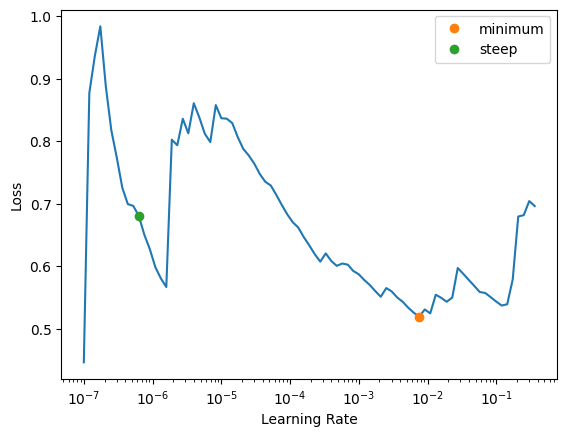

In [11]:
if trainNewModel:
    learn = tabular_learner(dls, metrics=[rmse, mae])

    # Learning rate finder
    lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

    # Debugging information
    print(f"Learning rate finder results: lr_min={lr_min}, lr_steep={lr_steep}")

    # Check if learning rates are valid
    if lr_min is None or lr_steep is None:
        raise ValueError("Learning rate finder did not return valid learning rates.")

    # Train
    print(f"Training for {epochs} epochs...")
    learn.fit_one_cycle(epochs, lr_max=lr_steep)
    print("Model training complete")

    learn.export(modelFolder / f'{modelName}.pkl')

## Testing and benchmarking

$HNT: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$FONE: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for HNT: No historical data available for HNT around 2024-01-27.
Error fetching data for FONE: No historical data available for FONE around 2024-01-27.


$VLCCF: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for VLCCF: No historical data available for VLCCF around 2024-01-27.


$SNHN: possibly delisted; no timezone found


Error fetching data for SNHN: No historical data available for SNHN around 2024-01-27.


$ATRI: possibly delisted; no timezone found
$PCCC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ATRI: No historical data available for ATRI around 2024-01-27.
Error fetching data for PCCC: No historical data available for PCCC around 2024-01-27.


$CTZ-A: possibly delisted; no timezone found
$ALOG: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CTZ-A: No historical data available for CTZ-A around 2024-01-27.
Error fetching data for ALOG: No historical data available for ALOG around 2024-01-27.


$PBI-B: possibly delisted; no timezone found


Error fetching data for PBI-B: No historical data available for PBI-B around 2024-01-27.


$FRAN: possibly delisted; no timezone found


Error fetching data for FRAN: No historical data available for FRAN around 2024-01-27.


$ATVI: possibly delisted; no timezone found


Error fetching data for ATVI: No historical data available for ATVI around 2024-01-27.


$MBRG: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for MBRG: No historical data available for MBRG around 2024-01-27.


$ABC: possibly delisted; no timezone found


Error fetching data for ABC: No historical data available for ABC around 2024-01-27.


$HBA-D: possibly delisted; no timezone found


Error fetching data for HBA-D: No historical data available for HBA-D around 2024-01-27.


$ABFS: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ABFS: No historical data available for ABFS around 2024-01-27.


$NVGN: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for NVGN: No historical data available for NVGN around 2024-01-27.


$MFI: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27) (Yahoo error = "Data doesn't exist for startDate = 1703739600, endDate = 1706331600")


Error fetching data for MFI: No historical data available for MFI around 2024-01-27.


$GPE-A: possibly delisted; no timezone found


Error fetching data for GPE-A: No historical data available for GPE-A around 2024-01-27.


$IBTX: possibly delisted; no price data found  (period=1d)


Error fetching data for IBTX: single positional indexer is out-of-bounds


$MFB: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for MFB: No historical data available for MFB around 2024-01-27.


$TI.A: possibly delisted; no timezone found
$HFFC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$RNE: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for TI.A: No historical data available for TI.A around 2024-01-27.
Error fetching data for HFFC: No historical data available for HFFC around 2024-01-27.
Error fetching data for RNE: No historical data available for RNE around 2024-01-27.


$ARMH: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ARMH: No historical data available for ARMH around 2024-01-27.


$RADA: possibly delisted; no timezone found


Error fetching data for RADA: No historical data available for RADA around 2024-01-27.


$NYLD: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for NYLD: No historical data available for NYLD around 2024-01-27.


$HTGY: possibly delisted; no timezone found
$BCA: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$KMP: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for HTGY: No historical data available for HTGY around 2024-01-27.
Error fetching data for BCA: No historical data available for BCA around 2024-01-27.
Error fetching data for KMP: No historical data available for KMP around 2024-01-27.


$HIH: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for HIH: No historical data available for HIH around 2024-01-27.


$PWX: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for PWX: No historical data available for PWX around 2024-01-27.


$TEU-C: possibly delisted; no timezone found


Error fetching data for TEU-C: No historical data available for TEU-C around 2024-01-27.


$GTN.A: possibly delisted; no timezone found


Error fetching data for GTN.A: No historical data available for GTN.A around 2024-01-27.


$AIRM: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$BCSB: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$RLD: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for AIRM: No historical data available for AIRM around 2024-01-27.
Error fetching data for BCSB: No historical data available for BCSB around 2024-01-27.
Error fetching data for RLD: No historical data available for RLD around 2024-01-27.


$MICT: possibly delisted; no timezone found
$CPLA: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for MICT: No historical data available for MICT around 2024-01-27.
Error fetching data for CPLA: No historical data available for CPLA around 2024-01-27.


$CISAA: possibly delisted; no timezone found


Error fetching data for CISAA: No historical data available for CISAA around 2024-01-27.


$OFG-A: possibly delisted; no timezone found
$IPCC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for OFG-A: No historical data available for OFG-A around 2024-01-27.
Error fetching data for IPCC: No historical data available for IPCC around 2024-01-27.


CBI: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']
$PCO: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CBI: single positional indexer is out-of-bounds
Error fetching data for PCO: No historical data available for PCO around 2024-01-27.


$EAGLU: possibly delisted; no timezone found
$APOL: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for EAGLU: No historical data available for EAGLU around 2024-01-27.
Error fetching data for APOL: No historical data available for APOL around 2024-01-27.


$RBS-Q: possibly delisted; no timezone found


Error fetching data for RBS-Q: No historical data available for RBS-Q around 2024-01-27.


$CERE: possibly delisted; no timezone found


Error fetching data for CERE: No historical data available for CERE around 2024-01-27.


$POPE: possibly delisted; no timezone found


Error fetching data for POPE: No historical data available for POPE around 2024-01-27.


$CYTX: possibly delisted; no timezone found


Error fetching data for CYTX: No historical data available for CYTX around 2024-01-27.


$CYN-C: possibly delisted; no timezone found
$VDSI: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CYN-C: No historical data available for CYN-C around 2024-01-27.
Error fetching data for VDSI: No historical data available for VDSI around 2024-01-27.


$MMP: possibly delisted; no timezone found


Error fetching data for MMP: No historical data available for MMP around 2024-01-27.


$CHDX: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CHDX: No historical data available for CHDX around 2024-01-27.


$AKS: possibly delisted; no timezone found


Error fetching data for AKS: No historical data available for AKS around 2024-01-27.


$RBS-N: possibly delisted; no timezone found


Error fetching data for RBS-N: No historical data available for RBS-N around 2024-01-27.


$HGT: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for HGT: No historical data available for HGT around 2024-01-27.


$SPAR: possibly delisted; no timezone found
$CVB: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for SPAR: No historical data available for SPAR around 2024-01-27.
Error fetching data for CVB: No historical data available for CVB around 2024-01-27.


$PSA-P: possibly delisted; no timezone found


Error fetching data for PSA-P: No historical data available for PSA-P around 2024-01-27.


$NEPT: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for NEPT: No historical data available for NEPT around 2024-01-27.


$ATRM: possibly delisted; no timezone found
$NPD: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ATRM: No historical data available for ATRM around 2024-01-27.
Error fetching data for NPD: No historical data available for NPD around 2024-01-27.


$STRZB: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$ESRX: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for STRZB: No historical data available for STRZB around 2024-01-27.
Error fetching data for ESRX: No historical data available for ESRX around 2024-01-27.


$OAKS: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for OAKS: No historical data available for OAKS around 2024-01-27.


$GAB-H: possibly delisted; no timezone found


Error fetching data for GAB-H: No historical data available for GAB-H around 2024-01-27.


$HMA: possibly delisted; no timezone found


Error fetching data for HMA: No historical data available for HMA around 2024-01-27.


$TCO-K: possibly delisted; no timezone found


Error fetching data for TCO-K: No historical data available for TCO-K around 2024-01-27.


$XGTI: possibly delisted; no timezone found
$MBIS: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for XGTI: No historical data available for XGTI around 2024-01-27.
Error fetching data for MBIS: No historical data available for MBIS around 2024-01-27.


$DMND: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for DMND: No historical data available for DMND around 2024-01-27.


$CBO: possibly delisted; no timezone found


Error fetching data for CBO: No historical data available for CBO around 2024-01-27.


$MWO: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for MWO: No historical data available for MWO around 2024-01-27.


$BCEI: possibly delisted; no timezone found


Error fetching data for BCEI: No historical data available for BCEI around 2024-01-27.


$CHS: possibly delisted; no timezone found


Error fetching data for CHS: No historical data available for CHS around 2024-01-27.


$TA: possibly delisted; no timezone found


Error fetching data for TA: No historical data available for TA around 2024-01-27.


$MICTW: possibly delisted; no timezone found


Error fetching data for MICTW: No historical data available for MICTW around 2024-01-27.


$NEE-G: possibly delisted; no timezone found


Error fetching data for NEE-G: No historical data available for NEE-G around 2024-01-27.


$PER: possibly delisted; no timezone found


Error fetching data for PER: No historical data available for PER around 2024-01-27.


$ARPI: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$HTR: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ARPI: No historical data available for ARPI around 2024-01-27.
Error fetching data for HTR: No historical data available for HTR around 2024-01-27.


$EDS: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for EDS: No historical data available for EDS around 2024-01-27.


$GPT-A: possibly delisted; no timezone found


Error fetching data for GPT-A: No historical data available for GPT-A around 2024-01-27.


$CRAY: possibly delisted; no timezone found


Error fetching data for CRAY: No historical data available for CRAY around 2024-01-27.


$CNDO: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CNDO: No historical data available for CNDO around 2024-01-27.


$ICA: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ICA: No historical data available for ICA around 2024-01-27.


$BKCC: possibly delisted; no timezone found


Error fetching data for BKCC: No historical data available for BKCC around 2024-01-27.


$NATI: possibly delisted; no timezone found
$XRSC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for NATI: No historical data available for NATI around 2024-01-27.
Error fetching data for XRSC: No historical data available for XRSC around 2024-01-27.


$DCIN: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for DCIN: No historical data available for DCIN around 2024-01-27.


$CPST: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27) (Yahoo error = "Data doesn't exist for startDate = 1703739600, endDate = 1706331600")


Error fetching data for CPST: No historical data available for CPST around 2024-01-27.


$ARCW: possibly delisted; no timezone found
$NTK: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$PZZI: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ARCW: No historical data available for ARCW around 2024-01-27.
Error fetching data for NTK: No historical data available for NTK around 2024-01-27.
Error fetching data for PZZI: No historical data available for PZZI around 2024-01-27.


$SFI-D: possibly delisted; no timezone found
$RCAP: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for SFI-D: No historical data available for SFI-D around 2024-01-27.
Error fetching data for RCAP: No historical data available for RCAP around 2024-01-27.


$KHI: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for KHI: No historical data available for KHI around 2024-01-27.


$ARNA: possibly delisted; no timezone found
$AMCC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ARNA: No historical data available for ARNA around 2024-01-27.
Error fetching data for AMCC: No historical data available for AMCC around 2024-01-27.


$NSL: possibly delisted; no timezone found


Error fetching data for NSL: No historical data available for NSL around 2024-01-27.


$SBNY: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27) (Yahoo error = "Data doesn't exist for startDate = 1703739600, endDate = 1706331600")


Error fetching data for SBNY: No historical data available for SBNY around 2024-01-27.


$LHCG: possibly delisted; no timezone found


Error fetching data for LHCG: No historical data available for LHCG around 2024-01-27.


$USU: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for USU: No historical data available for USU around 2024-01-27.


$SPEX: possibly delisted; no timezone found


Error fetching data for SPEX: No historical data available for SPEX around 2024-01-27.


$CST: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CST: No historical data available for CST around 2024-01-27.


$HW: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for HW: No historical data available for HW around 2024-01-27.


$VISN: possibly delisted; no timezone found


Error fetching data for VISN: No historical data available for VISN around 2024-01-27.


$USAT: possibly delisted; no timezone found


Error fetching data for USAT: No historical data available for USAT around 2024-01-27.


$MSP: possibly delisted; no timezone found


Error fetching data for MSP: No historical data available for MSP around 2024-01-27.


$WILN: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for WILN: No historical data available for WILN around 2024-01-27.


$AVP: possibly delisted; no timezone found


Error fetching data for AVP: No historical data available for AVP around 2024-01-27.


$TSS: possibly delisted; no timezone found
$FWLT: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for TSS: No historical data available for TSS around 2024-01-27.
Error fetching data for FWLT: No historical data available for FWLT around 2024-01-27.


$SMS: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for SMS: No historical data available for SMS around 2024-01-27.


$DO: possibly delisted; no timezone found


Error fetching data for DO: No historical data available for DO around 2024-01-27.


$LNCE: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for LNCE: No historical data available for LNCE around 2024-01-27.


$HOLI: possibly delisted; no timezone found


Error fetching data for HOLI: No historical data available for HOLI around 2024-01-27.


$OILT: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27) (Yahoo error = "Data doesn't exist for startDate = 1703739600, endDate = 1706331600")


Error fetching data for OILT: No historical data available for OILT around 2024-01-27.


$FRED: possibly delisted; no timezone found
$Q: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for FRED: No historical data available for FRED around 2024-01-27.
Error fetching data for Q: No historical data available for Q around 2024-01-27.


$CHL: possibly delisted; no timezone found


Error fetching data for CHL: No historical data available for CHL around 2024-01-27.


$MGLN: possibly delisted; no timezone found


Error fetching data for MGLN: No historical data available for MGLN around 2024-01-27.


$QLGC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$COBK: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for QLGC: No historical data available for QLGC around 2024-01-27.
Error fetching data for COBK: No historical data available for COBK around 2024-01-27.


$ISCA: possibly delisted; no timezone found
$CNQR: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ISCA: No historical data available for ISCA around 2024-01-27.
Error fetching data for CNQR: No historical data available for CNQR around 2024-01-27.


$QIWI: possibly delisted; no price data found  (period=1d)


Error fetching data for QIWI: single positional indexer is out-of-bounds


$SINO: possibly delisted; no timezone found


Error fetching data for SINO: No historical data available for SINO around 2024-01-27.


$SSW-D: possibly delisted; no timezone found
$CACGU: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for SSW-D: No historical data available for SSW-D around 2024-01-27.
Error fetching data for CACGU: No historical data available for CACGU around 2024-01-27.


$BWC: possibly delisted; no timezone found
$MKTG: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for BWC: No historical data available for BWC around 2024-01-27.
Error fetching data for MKTG: No historical data available for MKTG around 2024-01-27.


$FBSS: possibly delisted; no timezone found


Error fetching data for FBSS: No historical data available for FBSS around 2024-01-27.


$SUNS: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27) (Yahoo error = "Data doesn't exist for startDate = 1703739600, endDate = 1706331600")


Error fetching data for SUNS: No historical data available for SUNS around 2024-01-27.


$ZIXI: possibly delisted; no timezone found


Error fetching data for ZIXI: No historical data available for ZIXI around 2024-01-27.


$CCG-A: possibly delisted; no timezone found


Error fetching data for CCG-A: No historical data available for CCG-A around 2024-01-27.


$APFC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$BOXC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$EOPN: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for APFC: No historical data available for APFC around 2024-01-27.
Error fetching data for BOXC: No historical data available for BOXC around 2024-01-27.
Error fetching data for EOPN: No historical data available for EOPN around 2024-01-27.


$HT-B: possibly delisted; no timezone found


Error fetching data for HT-B: No historical data available for HT-B around 2024-01-27.


$NICK: possibly delisted; no timezone found


Error fetching data for NICK: No historical data available for NICK around 2024-01-27.


$STO: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$YONG: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for STO: No historical data available for STO around 2024-01-27.
Error fetching data for YONG: No historical data available for YONG around 2024-01-27.


$ADEP: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$AFFX: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$PERY: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ADEP: No historical data available for ADEP around 2024-01-27.
Error fetching data for AFFX: No historical data available for AFFX around 2024-01-27.
Error fetching data for PERY: No historical data available for PERY around 2024-01-27.


$THI: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$RJET: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for THI: No historical data available for THI around 2024-01-27.
Error fetching data for RJET: No historical data available for RJET around 2024-01-27.


$DRYS: possibly delisted; no timezone found


Error fetching data for DRYS: No historical data available for DRYS around 2024-01-27.


$NYNY: possibly delisted; no timezone found


Error fetching data for NYNY: No historical data available for NYNY around 2024-01-27.


$JST: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for JST: No historical data available for JST around 2024-01-27.


$DOVR: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for DOVR: No historical data available for DOVR around 2024-01-27.


$CELG: possibly delisted; no timezone found


Error fetching data for CELG: No historical data available for CELG around 2024-01-27.


$SWC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$NAVR: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$KEYW: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for SWC: No historical data available for SWC around 2024-01-27.
Error fetching data for NAVR: No historical data available for NAVR around 2024-01-27.
Error fetching data for KEYW: No historical data available for KEYW around 2024-01-27.


$RNO: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for RNO: No historical data available for RNO around 2024-01-27.


$ACO: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ACO: No historical data available for ACO around 2024-01-27.


$END: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$GMK: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for END: No historical data available for END around 2024-01-27.
Error fetching data for GMK: No historical data available for GMK around 2024-01-27.


$TMK-B: possibly delisted; no timezone found


Error fetching data for TMK-B: No historical data available for TMK-B around 2024-01-27.


$DTQ: possibly delisted; no timezone found


Error fetching data for DTQ: No historical data available for DTQ around 2024-01-27.


$EMMT: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for EMMT: No historical data available for EMMT around 2024-01-27.


$JPM.W: possibly delisted; no timezone found


Error fetching data for JPM.W: No historical data available for JPM.W around 2024-01-27.


$ASIA: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27) (Yahoo error = "Data doesn't exist for startDate = 1703739600, endDate = 1706331600")
$XAA: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ASIA: No historical data available for ASIA around 2024-01-27.
Error fetching data for XAA: No historical data available for XAA around 2024-01-27.


$UAM: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for UAM: No historical data available for UAM around 2024-01-27.


$GBL: possibly delisted; no timezone found


Error fetching data for GBL: No historical data available for GBL around 2024-01-27.


$PRE-E: possibly delisted; no timezone found


Error fetching data for PRE-E: No historical data available for PRE-E around 2024-01-27.


$MOLXA: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for MOLXA: No historical data available for MOLXA around 2024-01-27.


$FBC: possibly delisted; no timezone found


Error fetching data for FBC: No historical data available for FBC around 2024-01-27.


$GLF: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$CRME: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for GLF: No historical data available for GLF around 2024-01-27.
Error fetching data for CRME: No historical data available for CRME around 2024-01-27.


$FRBK: possibly delisted; no timezone found


Error fetching data for FRBK: No historical data available for FRBK around 2024-01-27.


$RSO-B: possibly delisted; no timezone found


Error fetching data for RSO-B: No historical data available for RSO-B around 2024-01-27.


$TGE: possibly delisted; no timezone found
$ESBF: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for TGE: No historical data available for TGE around 2024-01-27.
Error fetching data for ESBF: No historical data available for ESBF around 2024-01-27.


$EAC: possibly delisted; no timezone found
$AMRI: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for EAC: No historical data available for EAC around 2024-01-27.
Error fetching data for AMRI: No historical data available for AMRI around 2024-01-27.


$UBOH: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27) (Yahoo error = "Data doesn't exist for startDate = 1703739600, endDate = 1706331600")


Error fetching data for UBOH: No historical data available for UBOH around 2024-01-27.


$C-N: possibly delisted; no timezone found


Error fetching data for C-N: No historical data available for C-N around 2024-01-27.


$SDLP: possibly delisted; no timezone found


Error fetching data for SDLP: No historical data available for SDLP around 2024-01-27.


$RPXC: possibly delisted; no timezone found


Error fetching data for RPXC: No historical data available for RPXC around 2024-01-27.


$SGMS: possibly delisted; no timezone found
$SLXP: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for SGMS: No historical data available for SGMS around 2024-01-27.
Error fetching data for SLXP: No historical data available for SLXP around 2024-01-27.


$MAXY: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for MAXY: No historical data available for MAXY around 2024-01-27.


$WIBC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for WIBC: No historical data available for WIBC around 2024-01-27.


$GLT: possibly delisted; no timezone found


Error fetching data for GLT: No historical data available for GLT around 2024-01-27.


$ABIO: possibly delisted; no timezone found


Error fetching data for ABIO: No historical data available for ABIO around 2024-01-27.


$VOLC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$BSDM: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for VOLC: No historical data available for VOLC around 2024-01-27.
Error fetching data for BSDM: No historical data available for BSDM around 2024-01-27.


$CARB: possibly delisted; no timezone found
$JMI: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CARB: No historical data available for CARB around 2024-01-27.
Error fetching data for JMI: No historical data available for JMI around 2024-01-27.


$BML-H: possibly delisted; no timezone found


Error fetching data for BML-H: No historical data available for BML-H around 2024-01-27.


$CVO: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$PNRA: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$VOCS: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CVO: No historical data available for CVO around 2024-01-27.
Error fetching data for PNRA: No historical data available for PNRA around 2024-01-27.
Error fetching data for VOCS: No historical data available for VOCS around 2024-01-27.


$ROICU: possibly delisted; no timezone found


Error fetching data for ROICU: No historical data available for ROICU around 2024-01-27.


$LGP: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for LGP: No historical data available for LGP around 2024-01-27.


$TSRO: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$GTIV: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for TSRO: No historical data available for TSRO around 2024-01-27.
Error fetching data for GTIV: No historical data available for GTIV around 2024-01-27.


CBA: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']


Error fetching data for CBA: single positional indexer is out-of-bounds


$NMY-H: possibly delisted; no timezone found


Error fetching data for NMY-H: No historical data available for NMY-H around 2024-01-27.


$PBY: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$MPEL: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for PBY: No historical data available for PBY around 2024-01-27.
Error fetching data for MPEL: No historical data available for MPEL around 2024-01-27.


$BLT: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for BLT: No historical data available for BLT around 2024-01-27.


$GSVC: possibly delisted; no timezone found
$AEC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for GSVC: No historical data available for GSVC around 2024-01-27.
Error fetching data for AEC: No historical data available for AEC around 2024-01-27.


$ANAC: possibly delisted; no timezone found


Error fetching data for ANAC: No historical data available for ANAC around 2024-01-27.


$NNC-F: possibly delisted; no timezone found


Error fetching data for NNC-F: No historical data available for NNC-F around 2024-01-27.


$NEE-C: possibly delisted; no timezone found


Error fetching data for NEE-C: No historical data available for NEE-C around 2024-01-27.


$ZB-F: possibly delisted; no timezone found
$ETE: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ZB-F: No historical data available for ZB-F around 2024-01-27.
Error fetching data for ETE: No historical data available for ETE around 2024-01-27.


$PACQW: possibly delisted; no timezone found


Error fetching data for PACQW: No historical data available for PACQW around 2024-01-27.


$NGPC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for NGPC: No historical data available for NGPC around 2024-01-27.


$APC: possibly delisted; no timezone found


Error fetching data for APC: No historical data available for APC around 2024-01-27.


$KFH: possibly delisted; no timezone found
$LVLT: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for KFH: No historical data available for KFH around 2024-01-27.
Error fetching data for LVLT: No historical data available for LVLT around 2024-01-27.


$ITG: possibly delisted; no timezone found
$FFKY: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ITG: No historical data available for ITG around 2024-01-27.
Error fetching data for FFKY: No historical data available for FFKY around 2024-01-27.


$GE-A: possibly delisted; no timezone found


Error fetching data for GE-A: No historical data available for GE-A around 2024-01-27.


$MP-D: possibly delisted; no timezone found


Error fetching data for MP-D: No historical data available for MP-D around 2024-01-27.


$JRO: possibly delisted; no timezone found


Error fetching data for JRO: No historical data available for JRO around 2024-01-27.


$BGE-B: possibly delisted; no timezone found


Error fetching data for BGE-B: No historical data available for BGE-B around 2024-01-27.


$MTB-A: possibly delisted; no timezone found


Error fetching data for MTB-A: No historical data available for MTB-A around 2024-01-27.


$CSRE: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CSRE: No historical data available for CSRE around 2024-01-27.


$STI.A: possibly delisted; no timezone found


Error fetching data for STI.A: No historical data available for STI.A around 2024-01-27.


$BML-L: possibly delisted; no timezone found
$ANAD: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$PSTB: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for BML-L: No historical data available for BML-L around 2024-01-27.
Error fetching data for ANAD: No historical data available for ANAD around 2024-01-27.
Error fetching data for PSTB: No historical data available for PSTB around 2024-01-27.


$HJV: possibly delisted; no timezone found


Error fetching data for HJV: No historical data available for HJV around 2024-01-27.


$WPPGY: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for WPPGY: No historical data available for WPPGY around 2024-01-27.


$BML-I: possibly delisted; no timezone found


Error fetching data for BML-I: No historical data available for BML-I around 2024-01-27.


$LINE: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27) (Yahoo error = "Data doesn't exist for startDate = 1703739600, endDate = 1706331600")
$SYMX: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for LINE: No historical data available for LINE around 2024-01-27.
Error fetching data for SYMX: No historical data available for SYMX around 2024-01-27.


$AVHI: possibly delisted; no timezone found


Error fetching data for AVHI: No historical data available for AVHI around 2024-01-27.


$GEK: possibly delisted; no timezone found


Error fetching data for GEK: No historical data available for GEK around 2024-01-27.


$EGOV: possibly delisted; no timezone found


Error fetching data for EGOV: No historical data available for EGOV around 2024-01-27.


$PNTR: possibly delisted; no timezone found


Error fetching data for PNTR: No historical data available for PNTR around 2024-01-27.


$GHL: possibly delisted; no timezone found


Error fetching data for GHL: No historical data available for GHL around 2024-01-27.


$USMD: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for USMD: No historical data available for USMD around 2024-01-27.


$EQU: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for EQU: No historical data available for EQU around 2024-01-27.


$HCBK: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for HCBK: No historical data available for HCBK around 2024-01-27.


$HLS: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for HLS: No historical data available for HLS around 2024-01-27.


$HL-B: possibly delisted; no timezone found


Error fetching data for HL-B: No historical data available for HL-B around 2024-01-27.


$NPV-C: possibly delisted; no timezone found
$WBCO: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for NPV-C: No historical data available for NPV-C around 2024-01-27.
Error fetching data for WBCO: No historical data available for WBCO around 2024-01-27.


$BFS-C: possibly delisted; no timezone found


Error fetching data for BFS-C: No historical data available for BFS-C around 2024-01-27.


$BBRG: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for BBRG: No historical data available for BBRG around 2024-01-27.


$TDA: possibly delisted; no timezone found


Error fetching data for TDA: No historical data available for TDA around 2024-01-27.


$AUQ: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$DCA: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$GUA: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for AUQ: No historical data available for AUQ around 2024-01-27.
Error fetching data for DCA: No historical data available for DCA around 2024-01-27.
Error fetching data for GUA: No historical data available for GUA around 2024-01-27.
Error fetching data for FCNCA: Expecting value: line 1 column 1 (char 0)


$OCZ: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for OCZ: No historical data available for OCZ around 2024-01-27.


Failed to get ticker 'LFC' reason: Expecting value: line 1 column 1 (char 0)
$LFC: possibly delisted; no timezone found


Error fetching data for LFC: No historical data available for LFC around 2024-01-27.


Failed to get ticker 'C.A' reason: Expecting value: line 1 column 1 (char 0)
$C.A: possibly delisted; no timezone found


Error fetching data for C.A: No historical data available for C.A around 2024-01-27.


$BCO: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for BCO: No historical data available for BCO around 2024-01-27.


$MXT: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for MXT: No historical data available for MXT around 2024-01-27.


$IROQ: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for IROQ: No historical data available for IROQ around 2024-01-27.


$IRC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for IRC: No historical data available for IRC around 2024-01-27.


Failed to get ticker 'IRE-B' reason: Expecting value: line 1 column 1 (char 0)
$IRE-B: possibly delisted; no timezone found


Error fetching data for IRE-B: No historical data available for IRE-B around 2024-01-27.


Failed to get ticker 'PSB-R' reason: Expecting value: line 1 column 1 (char 0)
$PSB-R: possibly delisted; no timezone found


Error fetching data for PSB-R: No historical data available for PSB-R around 2024-01-27.


$RVT: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for RVT: No historical data available for RVT around 2024-01-27.


$DANG: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for DANG: No historical data available for DANG around 2024-01-27.


$PNFP: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for PNFP: No historical data available for PNFP around 2024-01-27.


$ATRC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ATRC: No historical data available for ATRC around 2024-01-27.


Failed to get ticker 'OVRL' reason: Expecting value: line 1 column 1 (char 0)
$OVRL: possibly delisted; no timezone found


Error fetching data for OVRL: No historical data available for OVRL around 2024-01-27.


Failed to get ticker 'CEM' reason: Expecting value: line 1 column 1 (char 0)
$CEM: possibly delisted; no timezone found


Error fetching data for CEM: No historical data available for CEM around 2024-01-27.


Failed to get ticker 'CCCL' reason: Expecting value: line 1 column 1 (char 0)
$CCCL: possibly delisted; no timezone found


Error fetching data for CCCL: No historical data available for CCCL around 2024-01-27.


$GAME: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for GAME: No historical data available for GAME around 2024-01-27.


$TNH: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for TNH: No historical data available for TNH around 2024-01-27.


$INGR: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for INGR: No historical data available for INGR around 2024-01-27.


$PMO: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for PMO: No historical data available for PMO around 2024-01-27.


$OVAS: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for OVAS: No historical data available for OVAS around 2024-01-27.


Failed to get ticker 'HYL' reason: Expecting value: line 1 column 1 (char 0)
$HYL: possibly delisted; no timezone found


Error fetching data for HYL: No historical data available for HYL around 2024-01-27.


$CGA: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CGA: No historical data available for CGA around 2024-01-27.


$THG: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for THG: No historical data available for THG around 2024-01-27.


Failed to get ticker 'GTAT' reason: Expecting value: line 1 column 1 (char 0)
$GTAT: possibly delisted; no timezone found


Error fetching data for GTAT: No historical data available for GTAT around 2024-01-27.


Failed to get ticker 'EBR.B' reason: Expecting value: line 1 column 1 (char 0)
$EBR.B: possibly delisted; no timezone found


Error fetching data for EBR.B: No historical data available for EBR.B around 2024-01-27.


$BSI: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for BSI: No historical data available for BSI around 2024-01-27.


$JOF: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for JOF: No historical data available for JOF around 2024-01-27.


$EMDR: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for EMDR: No historical data available for EMDR around 2024-01-27.


$RIO: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for RIO: No historical data available for RIO around 2024-01-27.


Failed to get ticker 'CHS-A' reason: Expecting value: line 1 column 1 (char 0)
$CHS-A: possibly delisted; no timezone found


Error fetching data for CHS-A: No historical data available for CHS-A around 2024-01-27.


$LOW: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for LOW: No historical data available for LOW around 2024-01-27.


$GWRE: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for GWRE: No historical data available for GWRE around 2024-01-27.


$CASY: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CASY: No historical data available for CASY around 2024-01-27.


Failed to get ticker 'WMGIZ' reason: Expecting value: line 1 column 1 (char 0)
$WMGIZ: possibly delisted; no timezone found


Error fetching data for WMGIZ: No historical data available for WMGIZ around 2024-01-27.


$GRR: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for GRR: No historical data available for GRR around 2024-01-27.


$LXP: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for LXP: No historical data available for LXP around 2024-01-27.


$TINY: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for TINY: No historical data available for TINY around 2024-01-27.


$CWST: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CWST: No historical data available for CWST around 2024-01-27.


$DHF: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for DHF: No historical data available for DHF around 2024-01-27.


$HEQ: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for HEQ: No historical data available for HEQ around 2024-01-27.


$L: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for L: No historical data available for L around 2024-01-27.


Failed to get ticker 'PRGX' reason: Expecting value: line 1 column 1 (char 0)
$PRGX: possibly delisted; no timezone found


Error fetching data for PRGX: No historical data available for PRGX around 2024-01-27.


Failed to get ticker 'IMCB' reason: Expecting value: line 1 column 1 (char 0)
$IMCB: possibly delisted; no timezone found


Error fetching data for IMCB: No historical data available for IMCB around 2024-01-27.


$GRPN: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for GRPN: No historical data available for GRPN around 2024-01-27.


$METR: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for METR: No historical data available for METR around 2024-01-27.


$MAG: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for MAG: No historical data available for MAG around 2024-01-27.


$SAP: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for SAP: No historical data available for SAP around 2024-01-27.


Failed to get ticker 'UIHC' reason: Expecting value: line 1 column 1 (char 0)
$UIHC: possibly delisted; no timezone found


Error fetching data for UIHC: No historical data available for UIHC around 2024-01-27.


Failed to get ticker 'NTC-D' reason: Expecting value: line 1 column 1 (char 0)
$NTC-D: possibly delisted; no timezone found


Error fetching data for NTC-D: No historical data available for NTC-D around 2024-01-27.


Failed to get ticker 'PEI-A' reason: Expecting value: line 1 column 1 (char 0)
$PEI-A: possibly delisted; no timezone found


Error fetching data for PEI-A: No historical data available for PEI-A around 2024-01-27.


Failed to get ticker 'DEI' reason: Expecting value: line 1 column 1 (char 0)
$DEI: possibly delisted; no timezone found


Error fetching data for DEI: No historical data available for DEI around 2024-01-27.


$RCS: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for RCS: No historical data available for RCS around 2024-01-27.


$ACW: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ACW: No historical data available for ACW around 2024-01-27.


$GBCI: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for GBCI: No historical data available for GBCI around 2024-01-27.


$GLW: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for GLW: No historical data available for GLW around 2024-01-27.


$IP: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for IP: No historical data available for IP around 2024-01-27.


$EXTR: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for EXTR: No historical data available for EXTR around 2024-01-27.


Failed to get ticker 'AMRB' reason: Expecting value: line 1 column 1 (char 0)
$AMRB: possibly delisted; no timezone found


Error fetching data for AMRB: No historical data available for AMRB around 2024-01-27.


Failed to get ticker 'MIC' reason: Expecting value: line 1 column 1 (char 0)
$MIC: possibly delisted; no timezone found


Error fetching data for MIC: No historical data available for MIC around 2024-01-27.


$CART: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CART: No historical data available for CART around 2024-01-27.


Failed to get ticker 'TCB.W' reason: Expecting value: line 1 column 1 (char 0)
$TCB.W: possibly delisted; no timezone found


Error fetching data for TCB.W: No historical data available for TCB.W around 2024-01-27.


Failed to get ticker 'IVAN' reason: Expecting value: line 1 column 1 (char 0)
$IVAN: possibly delisted; no timezone found


Error fetching data for IVAN: No historical data available for IVAN around 2024-01-27.


$PSCT: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for PSCT: No historical data available for PSCT around 2024-01-27.


Failed to get ticker 'SGYPW' reason: Expecting value: line 1 column 1 (char 0)
$SGYPW: possibly delisted; no timezone found


Error fetching data for SGYPW: No historical data available for SGYPW around 2024-01-27.


Failed to get ticker 'S' reason: Expecting value: line 1 column 1 (char 0)
$S: possibly delisted; no timezone found


Error fetching data for S: No historical data available for S around 2024-01-27.


Failed to get ticker 'AUY' reason: Expecting value: line 1 column 1 (char 0)
$AUY: possibly delisted; no timezone found


Error fetching data for AUY: No historical data available for AUY around 2024-01-27.


Failed to get ticker 'DL' reason: Expecting value: line 1 column 1 (char 0)
$DL: possibly delisted; no timezone found


Error fetching data for DL: No historical data available for DL around 2024-01-27.


Failed to get ticker 'IDSA' reason: Expecting value: line 1 column 1 (char 0)
$IDSA: possibly delisted; no timezone found


Error fetching data for IDSA: No historical data available for IDSA around 2024-01-27.


$KMM: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for KMM: No historical data available for KMM around 2024-01-27.


Failed to get ticker 'SAN-F' reason: Expecting value: line 1 column 1 (char 0)
$SAN-F: possibly delisted; no timezone found


Error fetching data for SAN-F: No historical data available for SAN-F around 2024-01-27.


$DMO: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for DMO: No historical data available for DMO around 2024-01-27.


$CKSW: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CKSW: No historical data available for CKSW around 2024-01-27.


$BRE: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for BRE: No historical data available for BRE around 2024-01-27.


Failed to get ticker 'ASRV' reason: Expecting value: line 1 column 1 (char 0)
$ASRV: possibly delisted; no timezone found


Error fetching data for ASRV: No historical data available for ASRV around 2024-01-27.


$PAAS: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for PAAS: No historical data available for PAAS around 2024-01-27.


$LTD: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for LTD: No historical data available for LTD around 2024-01-27.


Failed to get ticker 'KIM-H' reason: Expecting value: line 1 column 1 (char 0)
$KIM-H: possibly delisted; no timezone found


Error fetching data for KIM-H: No historical data available for KIM-H around 2024-01-27.


$TNXP: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for TNXP: No historical data available for TNXP around 2024-01-27.


$QRE: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for QRE: No historical data available for QRE around 2024-01-27.


$ESI: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ESI: No historical data available for ESI around 2024-01-27.


Failed to get ticker 'SCON' reason: Expecting value: line 1 column 1 (char 0)
$SCON: possibly delisted; no timezone found


Error fetching data for SCON: No historical data available for SCON around 2024-01-27.


$SSS: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for SSS: No historical data available for SSS around 2024-01-27.


Failed to get ticker 'MEILZ' reason: Expecting value: line 1 column 1 (char 0)
$MEILZ: possibly delisted; no timezone found


Error fetching data for MEILZ: No historical data available for MEILZ around 2024-01-27.


$NKA: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for NKA: No historical data available for NKA around 2024-01-27.


$HEES: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for HEES: No historical data available for HEES around 2024-01-27.


$CSTM: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CSTM: No historical data available for CSTM around 2024-01-27.


Failed to get ticker 'SMED' reason: Expecting value: line 1 column 1 (char 0)
$SMED: possibly delisted; no timezone found


Error fetching data for SMED: No historical data available for SMED around 2024-01-27.


Failed to get ticker 'INXBW' reason: Expecting value: line 1 column 1 (char 0)
$INXBW: possibly delisted; no timezone found


Error fetching data for INXBW: No historical data available for INXBW around 2024-01-27.


$PAR: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for PAR: No historical data available for PAR around 2024-01-27.


$GOLD: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for GOLD: No historical data available for GOLD around 2024-01-27.


Failed to get ticker 'OCR-A' reason: Expecting value: line 1 column 1 (char 0)
$OCR-A: possibly delisted; no timezone found


Error fetching data for OCR-A: No historical data available for OCR-A around 2024-01-27.


$TDY: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for TDY: No historical data available for TDY around 2024-01-27.


$GM: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for GM: No historical data available for GM around 2024-01-27.


$PSCI: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for PSCI: No historical data available for PSCI around 2024-01-27.


Failed to get ticker 'NES' reason: Expecting value: line 1 column 1 (char 0)
$NES: possibly delisted; no timezone found


Error fetching data for NES: No historical data available for NES around 2024-01-27.


Failed to get ticker 'MFV' reason: Expecting value: line 1 column 1 (char 0)
$MFV: possibly delisted; no timezone found


Error fetching data for MFV: No historical data available for MFV around 2024-01-27.


Failed to get ticker 'JONE' reason: Expecting value: line 1 column 1 (char 0)
$JONE: possibly delisted; no timezone found


Error fetching data for JONE: No historical data available for JONE around 2024-01-27.


$MPA: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for MPA: No historical data available for MPA around 2024-01-27.


Failed to get ticker 'CLN-A' reason: Expecting value: line 1 column 1 (char 0)
$CLN-A: possibly delisted; no timezone found


Error fetching data for CLN-A: No historical data available for CLN-A around 2024-01-27.


$BTU: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for BTU: No historical data available for BTU around 2024-01-27.


$EOG: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for EOG: No historical data available for EOG around 2024-01-27.


$RBA: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for RBA: No historical data available for RBA around 2024-01-27.


$ASG: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ASG: No historical data available for ASG around 2024-01-27.


Failed to get ticker 'TCB-B' reason: Expecting value: line 1 column 1 (char 0)
$TCB-B: possibly delisted; no timezone found


Error fetching data for TCB-B: No historical data available for TCB-B around 2024-01-27.


$VTHR: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for VTHR: No historical data available for VTHR around 2024-01-27.


Failed to get ticker 'KMF' reason: Expecting value: line 1 column 1 (char 0)
$KMF: possibly delisted; no timezone found


Error fetching data for KMF: No historical data available for KMF around 2024-01-27.


$EVER: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for EVER: No historical data available for EVER around 2024-01-27.


Failed to get ticker 'NPY' reason: Expecting value: line 1 column 1 (char 0)
$NPY: possibly delisted; no timezone found


Error fetching data for NPY: No historical data available for NPY around 2024-01-27.


Failed to get ticker 'ARE-E' reason: Expecting value: line 1 column 1 (char 0)
$ARE-E: possibly delisted; no timezone found


Error fetching data for ARE-E: No historical data available for ARE-E around 2024-01-27.


$EBTC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for EBTC: No historical data available for EBTC around 2024-01-27.


$GBAB: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for GBAB: No historical data available for GBAB around 2024-01-27.


Failed to get ticker 'FBS-A' reason: Expecting value: line 1 column 1 (char 0)
$FBS-A: possibly delisted; no timezone found


Error fetching data for FBS-A: No historical data available for FBS-A around 2024-01-27.


Failed to get ticker 'ANAT' reason: Expecting value: line 1 column 1 (char 0)
$ANAT: possibly delisted; no timezone found


Error fetching data for ANAT: No historical data available for ANAT around 2024-01-27.


$MCOX: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for MCOX: No historical data available for MCOX around 2024-01-27.


$SGMA: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for SGMA: No historical data available for SGMA around 2024-01-27.


$BMRN: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for BMRN: No historical data available for BMRN around 2024-01-27.


$FBNC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for FBNC: No historical data available for FBNC around 2024-01-27.


Failed to get ticker 'TAP.A' reason: Expecting value: line 1 column 1 (char 0)
$TAP.A: possibly delisted; no timezone found


Error fetching data for TAP.A: No historical data available for TAP.A around 2024-01-27.


$PERF: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for PERF: No historical data available for PERF around 2024-01-27.


Failed to get ticker 'ROYT' reason: Expecting value: line 1 column 1 (char 0)
$ROYT: possibly delisted; no timezone found


Error fetching data for ROYT: No historical data available for ROYT around 2024-01-27.


$NPBC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for NPBC: No historical data available for NPBC around 2024-01-27.


Failed to get ticker 'ASYS' reason: Expecting value: line 1 column 1 (char 0)
$ASYS: possibly delisted; no timezone found


Error fetching data for ASYS: No historical data available for ASYS around 2024-01-27.


$HBM: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for HBM: No historical data available for HBM around 2024-01-27.


$MTG: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for MTG: No historical data available for MTG around 2024-01-27.


Failed to get ticker 'GCVRZ' reason: Expecting value: line 1 column 1 (char 0)
$GCVRZ: possibly delisted; no timezone found


Error fetching data for GCVRZ: No historical data available for GCVRZ around 2024-01-27.


Failed to get ticker 'AFH' reason: Expecting value: line 1 column 1 (char 0)
$AFH: possibly delisted; no timezone found


Error fetching data for AFH: No historical data available for AFH around 2024-01-27.


Failed to get ticker 'ADVS' reason: Expecting value: line 1 column 1 (char 0)
$ADVS: possibly delisted; no timezone found


Error fetching data for ADVS: No historical data available for ADVS around 2024-01-27.


$GRFS: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for GRFS: No historical data available for GRFS around 2024-01-27.


$PCP: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for PCP: No historical data available for PCP around 2024-01-27.


Failed to get ticker 'ARQL' reason: Expecting value: line 1 column 1 (char 0)
$ARQL: possibly delisted; no timezone found


Error fetching data for ARQL: No historical data available for ARQL around 2024-01-27.


Failed to get ticker 'CYS-B' reason: Expecting value: line 1 column 1 (char 0)
$CYS-B: possibly delisted; no timezone found


Error fetching data for CYS-B: No historical data available for CYS-B around 2024-01-27.


$VRNM: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for VRNM: No historical data available for VRNM around 2024-01-27.


$MA: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for MA: No historical data available for MA around 2024-01-27.


$GTN: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for GTN: No historical data available for GTN around 2024-01-27.


$BKE: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for BKE: No historical data available for BKE around 2024-01-27.


$KEY: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for KEY: No historical data available for KEY around 2024-01-27.


$OMCL: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for OMCL: No historical data available for OMCL around 2024-01-27.


$COBZ: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for COBZ: No historical data available for COBZ around 2024-01-27.


Failed to get ticker 'NMFC' reason: Expecting value: line 1 column 1 (char 0)
$NMFC: possibly delisted; no timezone found


Error fetching data for NMFC: No historical data available for NMFC around 2024-01-27.


Failed to get ticker 'HJR' reason: Expecting value: line 1 column 1 (char 0)
$HJR: possibly delisted; no timezone found


Error fetching data for HJR: No historical data available for HJR around 2024-01-27.


$GIL: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for GIL: No historical data available for GIL around 2024-01-27.


$INTX: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for INTX: No historical data available for INTX around 2024-01-27.


$FITB: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for FITB: No historical data available for FITB around 2024-01-27.


$DFP: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for DFP: No historical data available for DFP around 2024-01-27.


$LND: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for LND: No historical data available for LND around 2024-01-27.


Failed to get ticker 'NEWT' reason: Expecting value: line 1 column 1 (char 0)
$NEWT: possibly delisted; no timezone found


Error fetching data for NEWT: No historical data available for NEWT around 2024-01-27.


Failed to get ticker 'SIBC' reason: Expecting value: line 1 column 1 (char 0)
$SIBC: possibly delisted; no timezone found


Error fetching data for SIBC: No historical data available for SIBC around 2024-01-27.


Failed to get ticker 'VSBN' reason: Expecting value: line 1 column 1 (char 0)
$VSBN: possibly delisted; no timezone found


Error fetching data for VSBN: No historical data available for VSBN around 2024-01-27.


$GERN: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for GERN: No historical data available for GERN around 2024-01-27.


Failed to get ticker 'TCP' reason: Expecting value: line 1 column 1 (char 0)
$TCP: possibly delisted; no timezone found


Error fetching data for TCP: No historical data available for TCP around 2024-01-27.


$AMCF: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for AMCF: No historical data available for AMCF around 2024-01-27.


$CXW: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CXW: No historical data available for CXW around 2024-01-27.


Failed to get ticker 'WLBPZ' reason: Expecting value: line 1 column 1 (char 0)
$WLBPZ: possibly delisted; no timezone found


Error fetching data for WLBPZ: No historical data available for WLBPZ around 2024-01-27.


$DRTX: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for DRTX: No historical data available for DRTX around 2024-01-27.


$IGD: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for IGD: No historical data available for IGD around 2024-01-27.


$NMRX: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for NMRX: No historical data available for NMRX around 2024-01-27.


$STEI: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for STEI: No historical data available for STEI around 2024-01-27.


Failed to get ticker 'CXH' reason: Expecting value: line 1 column 1 (char 0)
$CXH: possibly delisted; no timezone found


Error fetching data for CXH: No historical data available for CXH around 2024-01-27.


$AMZN: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for AMZN: No historical data available for AMZN around 2024-01-27.


Failed to get ticker 'LOR' reason: Expecting value: line 1 column 1 (char 0)
$LOR: possibly delisted; no timezone found


Error fetching data for LOR: No historical data available for LOR around 2024-01-27.


$CTCM: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CTCM: No historical data available for CTCM around 2024-01-27.


$FPO: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for FPO: No historical data available for FPO around 2024-01-27.


$PFMT: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for PFMT: No historical data available for PFMT around 2024-01-27.


$PZC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for PZC: No historical data available for PZC around 2024-01-27.


Failed to get ticker 'RBS' reason: Expecting value: line 1 column 1 (char 0)
$RBS: possibly delisted; no timezone found


Error fetching data for RBS: No historical data available for RBS around 2024-01-27.


$MSM: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for MSM: No historical data available for MSM around 2024-01-27.


$KRNY: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for KRNY: No historical data available for KRNY around 2024-01-27.


Failed to get ticker 'CORR' reason: Expecting value: line 1 column 1 (char 0)
$CORR: possibly delisted; no timezone found


Error fetching data for CORR: No historical data available for CORR around 2024-01-27.


$ERS: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ERS: No historical data available for ERS around 2024-01-27.


$HCKT: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for HCKT: No historical data available for HCKT around 2024-01-27.


$RUK: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for RUK: No historical data available for RUK around 2024-01-27.


Failed to get ticker 'HSB-B' reason: Expecting value: line 1 column 1 (char 0)
$HSB-B: possibly delisted; no timezone found


Error fetching data for HSB-B: No historical data available for HSB-B around 2024-01-27.


Failed to get ticker 'NANO' reason: Expecting value: line 1 column 1 (char 0)
$NANO: possibly delisted; no timezone found


Error fetching data for NANO: No historical data available for NANO around 2024-01-27.


$UCBA: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for UCBA: No historical data available for UCBA around 2024-01-27.


Failed to get ticker 'DATA' reason: Expecting value: line 1 column 1 (char 0)
$DATA: possibly delisted; no timezone found


Error fetching data for DATA: No historical data available for DATA around 2024-01-27.


$MUC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for MUC: No historical data available for MUC around 2024-01-27.


Failed to get ticker 'HCAP' reason: Expecting value: line 1 column 1 (char 0)
$HCAP: possibly delisted; no timezone found


Error fetching data for HCAP: No historical data available for HCAP around 2024-01-27.


$JKS: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for JKS: No historical data available for JKS around 2024-01-27.


$AH: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for AH: No historical data available for AH around 2024-01-27.


Failed to get ticker 'GOODP' reason: Expecting value: line 1 column 1 (char 0)
$GOODP: possibly delisted; no timezone found


Error fetching data for GOODP: No historical data available for GOODP around 2024-01-27.


$COSI: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for COSI: No historical data available for COSI around 2024-01-27.


Failed to get ticker 'ERA' reason: Expecting value: line 1 column 1 (char 0)
$ERA: possibly delisted; no timezone found


Error fetching data for ERA: No historical data available for ERA around 2024-01-27.


$BCRX: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for BCRX: No historical data available for BCRX around 2024-01-27.


$ADI: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ADI: No historical data available for ADI around 2024-01-27.


$KORS: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for KORS: No historical data available for KORS around 2024-01-27.


$PMF: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for PMF: No historical data available for PMF around 2024-01-27.


$STKL: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for STKL: No historical data available for STKL around 2024-01-27.


$XEL: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for XEL: No historical data available for XEL around 2024-01-27.


$PLUG: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for PLUG: No historical data available for PLUG around 2024-01-27.


Failed to get ticker 'NTC-F' reason: Expecting value: line 1 column 1 (char 0)
$NTC-F: possibly delisted; no timezone found


Error fetching data for NTC-F: No historical data available for NTC-F around 2024-01-27.


Failed to get ticker 'KBIO' reason: Expecting value: line 1 column 1 (char 0)
$KBIO: possibly delisted; no timezone found


Error fetching data for KBIO: No historical data available for KBIO around 2024-01-27.


Failed to get ticker 'HEP' reason: Expecting value: line 1 column 1 (char 0)
$HEP: possibly delisted; no timezone found


Error fetching data for HEP: No historical data available for HEP around 2024-01-27.


$DEG: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for DEG: No historical data available for DEG around 2024-01-27.


Failed to get ticker 'TCCA' reason: Expecting value: line 1 column 1 (char 0)
$TCCA: possibly delisted; no timezone found


Error fetching data for TCCA: No historical data available for TCCA around 2024-01-27.


Failed to get ticker 'GIII' reason: Expecting value: line 1 column 1 (char 0)
$GIII: possibly delisted; no timezone found


Error fetching data for GIII: No historical data available for GIII around 2024-01-27.


$AOSL: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for AOSL: No historical data available for AOSL around 2024-01-27.


$VRTS: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for VRTS: No historical data available for VRTS around 2024-01-27.


$ARLP: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ARLP: No historical data available for ARLP around 2024-01-27.


$GIVN: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for GIVN: No historical data available for GIVN around 2024-01-27.


Failed to get ticker 'EMZ' reason: Expecting value: line 1 column 1 (char 0)
$EMZ: possibly delisted; no timezone found


Error fetching data for EMZ: No historical data available for EMZ around 2024-01-27.


$PACR: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for PACR: No historical data available for PACR around 2024-01-27.


Failed to get ticker 'HP' reason: Expecting value: line 1 column 1 (char 0)
$HP: possibly delisted; no timezone found


Error fetching data for HP: No historical data available for HP around 2024-01-27.


$BRT: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for BRT: No historical data available for BRT around 2024-01-27.


$EDMC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for EDMC: No historical data available for EDMC around 2024-01-27.


$AES: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for AES: No historical data available for AES around 2024-01-27.


$EDF: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for EDF: No historical data available for EDF around 2024-01-27.


$CLRX: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CLRX: No historical data available for CLRX around 2024-01-27.


Failed to get ticker 'HK' reason: Expecting value: line 1 column 1 (char 0)
$HK: possibly delisted; no timezone found


Error fetching data for HK: No historical data available for HK around 2024-01-27.


$HBI: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for HBI: No historical data available for HBI around 2024-01-27.


Failed to get ticker 'LORL' reason: Expecting value: line 1 column 1 (char 0)
$LORL: possibly delisted; no timezone found


Error fetching data for LORL: No historical data available for LORL around 2024-01-27.


Failed to get ticker 'APU' reason: Expecting value: line 1 column 1 (char 0)
$APU: possibly delisted; no timezone found


Error fetching data for APU: No historical data available for APU around 2024-01-27.


Failed to get ticker 'CHTP' reason: Expecting value: line 1 column 1 (char 0)
$CHTP: possibly delisted; no timezone found


Error fetching data for CHTP: No historical data available for CHTP around 2024-01-27.


Failed to get ticker 'HAV' reason: Expecting value: line 1 column 1 (char 0)
$HAV: possibly delisted; no timezone found


Error fetching data for HAV: No historical data available for HAV around 2024-01-27.


Failed to get ticker 'TOWR' reason: Expecting value: line 1 column 1 (char 0)
$TOWR: possibly delisted; no timezone found


Error fetching data for TOWR: No historical data available for TOWR around 2024-01-27.


Failed to get ticker 'HMH' reason: Expecting value: line 1 column 1 (char 0)
$HMH: possibly delisted; no timezone found


Error fetching data for HMH: No historical data available for HMH around 2024-01-27.


Failed to get ticker 'EGLE' reason: Expecting value: line 1 column 1 (char 0)
$EGLE: possibly delisted; no timezone found


Error fetching data for EGLE: No historical data available for EGLE around 2024-01-27.


$VGLT: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for VGLT: No historical data available for VGLT around 2024-01-27.


$ISRG: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ISRG: No historical data available for ISRG around 2024-01-27.


$CITZ: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CITZ: No historical data available for CITZ around 2024-01-27.


$CAS: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CAS: No historical data available for CAS around 2024-01-27.


$KRC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for KRC: No historical data available for KRC around 2024-01-27.


Failed to get ticker 'AROW' reason: Expecting value: line 1 column 1 (char 0)
$AROW: possibly delisted; no timezone found


Error fetching data for AROW: No historical data available for AROW around 2024-01-27.


Failed to get ticker 'CACC' reason: Expecting value: line 1 column 1 (char 0)
$CACC: possibly delisted; no timezone found


Error fetching data for CACC: No historical data available for CACC around 2024-01-27.


$WOOF: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for WOOF: No historical data available for WOOF around 2024-01-27.


Failed to get ticker 'TNAV' reason: Expecting value: line 1 column 1 (char 0)
$TNAV: possibly delisted; no timezone found


Error fetching data for TNAV: No historical data available for TNAV around 2024-01-27.


$NMM: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for NMM: No historical data available for NMM around 2024-01-27.


Failed to get ticker 'FTT' reason: Expecting value: line 1 column 1 (char 0)
$FTT: possibly delisted; no timezone found


Error fetching data for FTT: No historical data available for FTT around 2024-01-27.


Failed to get ticker 'WEBK' reason: Expecting value: line 1 column 1 (char 0)
$WEBK: possibly delisted; no timezone found


Error fetching data for WEBK: No historical data available for WEBK around 2024-01-27.


$ONXX: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ONXX: No historical data available for ONXX around 2024-01-27.


Failed to get ticker 'O-E' reason: Expecting value: line 1 column 1 (char 0)
$O-E: possibly delisted; no timezone found


Error fetching data for O-E: No historical data available for O-E around 2024-01-27.


$FORR: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for FORR: No historical data available for FORR around 2024-01-27.


Failed to get ticker 'MDCO' reason: Expecting value: line 1 column 1 (char 0)
$MDCO: possibly delisted; no timezone found


Error fetching data for MDCO: No historical data available for MDCO around 2024-01-27.


Failed to get ticker 'TWMC' reason: Expecting value: line 1 column 1 (char 0)
$TWMC: possibly delisted; no timezone found


Error fetching data for TWMC: No historical data available for TWMC around 2024-01-27.


Failed to get ticker 'AT' reason: Expecting value: line 1 column 1 (char 0)
$AT: possibly delisted; no timezone found


Error fetching data for AT: No historical data available for AT around 2024-01-27.


$XNY: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for XNY: No historical data available for XNY around 2024-01-27.


$FFCO: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for FFCO: No historical data available for FFCO around 2024-01-27.


$BOE: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for BOE: No historical data available for BOE around 2024-01-27.


$GWW: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for GWW: No historical data available for GWW around 2024-01-27.


$EXPD: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for EXPD: No historical data available for EXPD around 2024-01-27.


$NPM: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for NPM: No historical data available for NPM around 2024-01-27.


Failed to get ticker 'CDR' reason: Expecting value: line 1 column 1 (char 0)
$CDR: possibly delisted; no timezone found


Error fetching data for CDR: No historical data available for CDR around 2024-01-27.


Failed to get ticker 'JMP' reason: Expecting value: line 1 column 1 (char 0)
$JMP: possibly delisted; no timezone found


Error fetching data for JMP: No historical data available for JMP around 2024-01-27.


$DXLG: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for DXLG: No historical data available for DXLG around 2024-01-27.


Failed to get ticker 'GOV' reason: Expecting value: line 1 column 1 (char 0)
$GOV: possibly delisted; no timezone found


Error fetching data for GOV: No historical data available for GOV around 2024-01-27.


Failed to get ticker 'WPCS' reason: Expecting value: line 1 column 1 (char 0)
$WPCS: possibly delisted; no timezone found


Error fetching data for WPCS: No historical data available for WPCS around 2024-01-27.


$CTAS: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CTAS: No historical data available for CTAS around 2024-01-27.


$PPBI: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for PPBI: No historical data available for PPBI around 2024-01-27.


Failed to get ticker 'RST' reason: Expecting value: line 1 column 1 (char 0)
$RST: possibly delisted; no timezone found


Error fetching data for RST: No historical data available for RST around 2024-01-27.


Failed to get ticker 'LSI' reason: Expecting value: line 1 column 1 (char 0)
$LSI: possibly delisted; no timezone found


Error fetching data for LSI: No historical data available for LSI around 2024-01-27.


$SCVL: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for SCVL: No historical data available for SCVL around 2024-01-27.


$ENG: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ENG: No historical data available for ENG around 2024-01-27.


Failed to get ticker 'TCB-C' reason: Expecting value: line 1 column 1 (char 0)
$TCB-C: possibly delisted; no timezone found


Error fetching data for TCB-C: No historical data available for TCB-C around 2024-01-27.


Failed to get ticker 'DLR-F' reason: Expecting value: line 1 column 1 (char 0)
$DLR-F: possibly delisted; no timezone found


Error fetching data for DLR-F: No historical data available for DLR-F around 2024-01-27.


$PBHC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for PBHC: No historical data available for PBHC around 2024-01-27.


Failed to get ticker 'IRR' reason: Expecting value: line 1 column 1 (char 0)
$IRR: possibly delisted; no timezone found


Error fetching data for IRR: No historical data available for IRR around 2024-01-27.


$FOR: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for FOR: No historical data available for FOR around 2024-01-27.


Failed to get ticker 'TNP' reason: Expecting value: line 1 column 1 (char 0)
$TNP: possibly delisted; no timezone found


Error fetching data for TNP: No historical data available for TNP around 2024-01-27.


$FNP: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for FNP: No historical data available for FNP around 2024-01-27.


$JBR: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for JBR: No historical data available for JBR around 2024-01-27.


$MSK: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for MSK: No historical data available for MSK around 2024-01-27.


$NTC: possibly delisted; no timezone found


Error fetching data for NTC: No historical data available for NTC around 2024-01-27.


$AQUUW: possibly delisted; no timezone found


Error fetching data for AQUUW: No historical data available for AQUUW around 2024-01-27.


$SAI: possibly delisted; no timezone found


Error fetching data for SAI: No historical data available for SAI around 2024-01-27.


$ARTX: possibly delisted; no timezone found


Error fetching data for ARTX: No historical data available for ARTX around 2024-01-27.


$RLH: possibly delisted; no timezone found
$BHD: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for RLH: No historical data available for RLH around 2024-01-27.
Error fetching data for BHD: No historical data available for BHD around 2024-01-27.


$NETC: possibly delisted; no timezone found


Error fetching data for NETC: No historical data available for NETC around 2024-01-27.


$EXLP: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for EXLP: No historical data available for EXLP around 2024-01-27.


$PRI.B: possibly delisted; no timezone found


Error fetching data for PRI.B: No historical data available for PRI.B around 2024-01-27.


$REG-F: possibly delisted; no timezone found
$TEG: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for REG-F: No historical data available for REG-F around 2024-01-27.
Error fetching data for TEG: No historical data available for TEG around 2024-01-27.


$SYMC: possibly delisted; no timezone found


Error fetching data for SYMC: No historical data available for SYMC around 2024-01-27.


$STON: possibly delisted; no timezone found


Error fetching data for STON: No historical data available for STON around 2024-01-27.


$NXQ: possibly delisted; no timezone found


Error fetching data for NXQ: No historical data available for NXQ around 2024-01-27.


$ORBC: possibly delisted; no timezone found
$SSH: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ORBC: No historical data available for ORBC around 2024-01-27.
Error fetching data for SSH: No historical data available for SSH around 2024-01-27.


$CHK-D: possibly delisted; no timezone found
$EVAC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CHK-D: No historical data available for CHK-D around 2024-01-27.
Error fetching data for EVAC: No historical data available for EVAC around 2024-01-27.


$TCO-J: possibly delisted; no timezone found


Error fetching data for TCO-J: No historical data available for TCO-J around 2024-01-27.


$GY: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for GY: No historical data available for GY around 2024-01-27.


$MCC: possibly delisted; no timezone found


Error fetching data for MCC: No historical data available for MCC around 2024-01-27.


$IKNX: possibly delisted; no timezone found


Error fetching data for IKNX: No historical data available for IKNX around 2024-01-27.


$ISH-A: possibly delisted; no timezone found


Error fetching data for ISH-A: No historical data available for ISH-A around 2024-01-27.


$THST: possibly delisted; no timezone found


Error fetching data for THST: No historical data available for THST around 2024-01-27.


HAWK: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']


Error fetching data for HAWK: single positional indexer is out-of-bounds


$FCH-C: possibly delisted; no timezone found


Error fetching data for FCH-C: No historical data available for FCH-C around 2024-01-27.


$CBLI: possibly delisted; no timezone found


Error fetching data for CBLI: No historical data available for CBLI around 2024-01-27.


$PLMT: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for PLMT: No historical data available for PLMT around 2024-01-27.


$IVC: possibly delisted; no timezone found


Error fetching data for IVC: No historical data available for IVC around 2024-01-27.


$PACQ: possibly delisted; no timezone found


Error fetching data for PACQ: No historical data available for PACQ around 2024-01-27.


$JMF: possibly delisted; no timezone found


Error fetching data for JMF: No historical data available for JMF around 2024-01-27.


$MRH: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for MRH: No historical data available for MRH around 2024-01-27.


$ERW: possibly delisted; no timezone found
$DRWI: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ERW: No historical data available for ERW around 2024-01-27.
Error fetching data for DRWI: No historical data available for DRWI around 2024-01-27.


$PGTI: possibly delisted; no timezone found


Error fetching data for PGTI: No historical data available for PGTI around 2024-01-27.


$CRR: possibly delisted; no timezone found


Error fetching data for CRR: No historical data available for CRR around 2024-01-27.


$PNC-Q: possibly delisted; no timezone found
$CMK: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for PNC-Q: No historical data available for PNC-Q around 2024-01-27.
Error fetching data for CMK: No historical data available for CMK around 2024-01-27.


$KNL: possibly delisted; no timezone found
$PYC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for KNL: No historical data available for KNL around 2024-01-27.
Error fetching data for PYC: No historical data available for PYC around 2024-01-27.


$ARK: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ARK: No historical data available for ARK around 2024-01-27.


$LAWS: possibly delisted; no timezone found


Error fetching data for LAWS: No historical data available for LAWS around 2024-01-27.


$TIF: possibly delisted; no timezone found


Error fetching data for TIF: No historical data available for TIF around 2024-01-27.


$RBS-P: possibly delisted; no timezone found
$VYFC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for RBS-P: No historical data available for RBS-P around 2024-01-27.
Error fetching data for VYFC: No historical data available for VYFC around 2024-01-27.


$BOCH: possibly delisted; no timezone found


Error fetching data for BOCH: No historical data available for BOCH around 2024-01-27.


$FFKT: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for FFKT: No historical data available for FFKT around 2024-01-27.


$MZOR: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for MZOR: No historical data available for MZOR around 2024-01-27.


$EPR-F: possibly delisted; no timezone found


Error fetching data for EPR-F: No historical data available for EPR-F around 2024-01-27.


$UBNK: possibly delisted; no timezone found


Error fetching data for UBNK: No historical data available for UBNK around 2024-01-27.


$OMG: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for OMG: No historical data available for OMG around 2024-01-27.


Logged evaluation results to c:\Users\Gamer\Documents\GitHub\VS-Code\Side-Projects\TrainedModels\stockScreener\modelEvaluations.csv


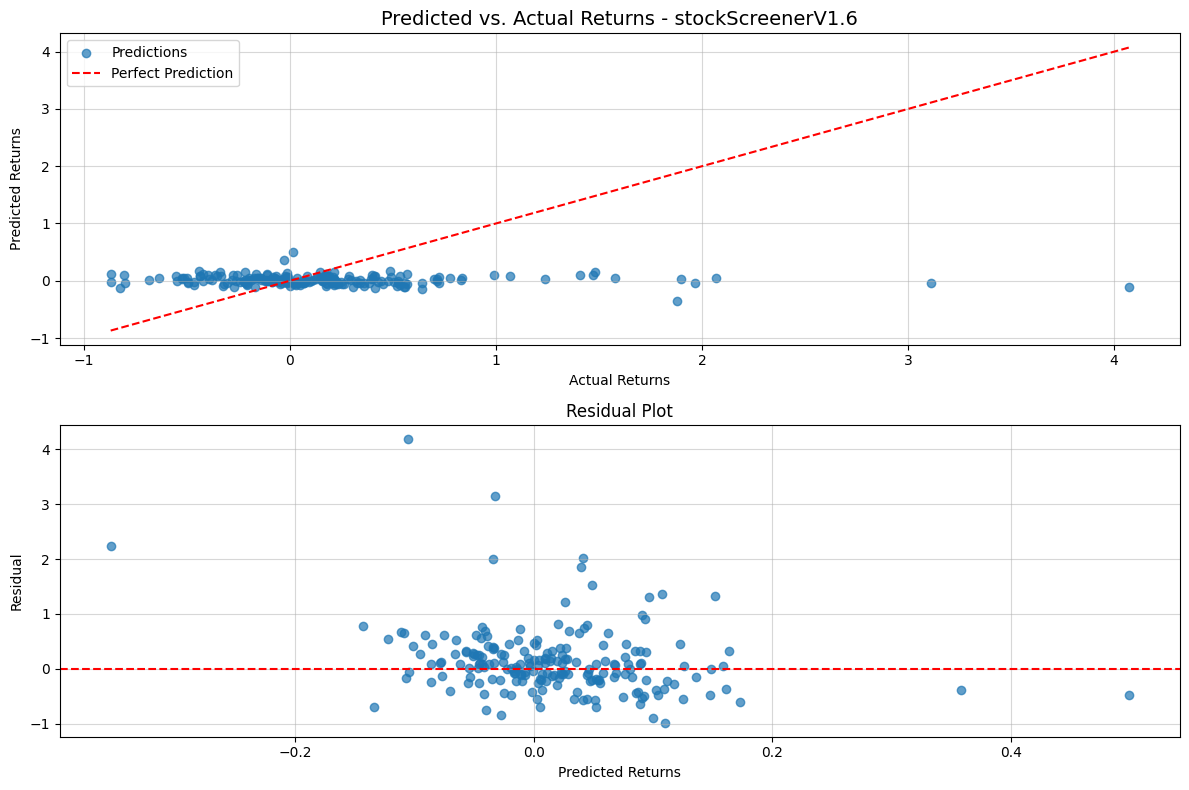

Collected 200 valid test tickers (target: 200)

Evaluation Results:
MAE: 0.400
RMSE: 0.636
R²: -0.108


In [12]:
def logEvaluation(model_name, mae, rmse, r2, model_folder, test_tickers):
    """Log evaluation metrics to CSV file"""
    log_file = model_folder / "modelEvaluations.csv"
    
    new_entry_df = pd.DataFrame([{
        "Model Name": model_name,
        "Timestamp": datetime.now().strftime('%Y-%m-%d %H:%M'),
        "MAE": f'{mae:.3f}',
        "RMSE": f'{rmse:.3f}',
        "R2": f'{r2:.3f}',
        "Epochs": epochs,
        "Training Size": trainingSize,
        "Test Size": len(test_tickers),
        "Cat Names": catNames,
        "Cont Names": contNames,
    }])
    
    try:
        log_df = pd.read_csv(log_file)
        log_df = pd.concat([log_df, new_entry_df], ignore_index=True)
    except FileNotFoundError:
        log_df = new_entry_df
        
    log_df.to_csv(log_file, index=False)
    print(f"Logged evaluation results to {log_file}")

def plotResults(results_df, model_name, model_folder):
    """Create and save visualization plots using all data points."""
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.scatter(results_df['Actual'], results_df['Predicted'], alpha=0.7, label='Predictions')
    min_val = min(results_df['Actual'].min(), results_df['Predicted'].min())
    max_val = max(results_df['Actual'].max(), results_df['Predicted'].max())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')
    plt.title(f'Predicted vs. Actual Returns - {model_name}', fontsize=14)
    plt.xlabel('Actual Returns')
    plt.ylabel('Predicted Returns')
    plt.legend()
    plt.grid(alpha=0.5)
    
    plt.subplot(2, 1, 2)
    plt.scatter(results_df['Predicted'], results_df['Residual'], alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residual Plot')
    plt.xlabel('Predicted Returns')
    plt.ylabel('Residual')
    plt.grid(alpha=0.5)
    
    plt.tight_layout()
    plt.show()

if trainNewModel:
    nonTrainingTickers = list(set(tickers) - set(trainingTickers))
    validTestData = []
    attempted_tickers = set()
    attempts = 0

    if testSize * 4 <= len(tickers):  
        max_attempts = testSize * 4 # Prevent infinite loops
    else:
        max_attempts = len(tickers)

    # Keep trying until we reach testSize or exhaust attempts
    while len(validTestData) < testSize and attempts < max_attempts:
        # Get a new ticker we haven't tried yet
        remaining_tickers = [t for t in nonTrainingTickers if t not in attempted_tickers]
        if not remaining_tickers:  # If all tried, reset attempted list
            attempted_tickers = set()
            remaining_tickers = nonTrainingTickers
            
        ticker = np.random.choice(remaining_tickers)
        attempted_tickers.add(ticker)
        attempts += 1

        # Fetch and validate data
        data = getTickerDataFrom1YrAgo(ticker)
        if not data.empty and not data[['EV/EBIT', 'ROIC']].isna().any().any():
            validTestData.append(data)

    if not validTestData:
        raise ValueError("No valid test data collected after multiple attempts")
        
    # Trim to exact testSize if we collected more
    validTestData = validTestData[:testSize]  
    combinedTestData = pd.concat(validTestData, ignore_index=True)

    # Clean data
    test_data_clean = combinedTestData.dropna(subset=['EV/EBIT', 'ROIC', 'Future Year Change'])
    
    if test_data_clean.empty:
        raise ValueError("No valid test data after cleaning NaN values")

    # Create test dataloader
    test_dl = learn.dls.test_dl(test_data_clean)
    preds, targs = learn.get_preds(dl=test_dl)
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'Predicted': preds.numpy().flatten(),
        'Actual': targs.numpy().flatten()
    })
    results_df['Residual'] = results_df['Actual'] - results_df['Predicted']

    # Calculate metrics
    mae = np.mean(np.abs(results_df['Residual']))
    rmse = np.sqrt(np.mean(results_df['Residual']**2))
    r2 = 1 - (np.sum(results_df['Residual']**2) / np.sum((results_df['Actual'] - results_df['Actual'].mean())**2))

    # Log and plot
    logEvaluation(modelName, mae, rmse, r2, modelFolder, test_data_clean['Ticker'].unique())
    plotResults(results_df, modelName, modelFolder)

    # Show collection stats
    print(f"Collected {len(validTestData)} valid test tickers (target: {testSize})")
    if attempts >= max_attempts:
        print(f"Warning: Reached max attempts ({max_attempts}). Some invalid tickers may remain.")  
    print(f"\nEvaluation Results:")
    print(f"MAE: {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²: {r2:.3f}")

## Predictions

In [18]:
print('Model files in modelFolder:')
for file in modelFolder.glob('*.pkl'):
    print(file.name)

Model files in modelFolder:
stockScreenerV1.0.pkl
stockScreenerV1.1.pkl
stockScreenerV1.2.pkl
stockScreenerV1.3.pkl
stockScreenerV1.4.pkl
stockScreenerV1.5.pkl
stockScreenerV1.6.pkl


In [19]:
evaluations = pd.read_csv(modelFolder / 'modelEvaluations.csv')
bestModel = evaluations.sort_values('MAE', ascending=True).iloc[0]
bestModel.head()

Model Name    stockScreenerV1.6
Timestamp      2025-01-26 21:33
MAE                         0.4
RMSE                      0.636
R2                       -0.108
Name: 6, dtype: object

### Load model

In [20]:
if os.name == 'nt':
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
else:
    pathlib.WindowsPath = pathlib.PosixPath

importedModel = Path(f"{bestModel['Model Name']}.pkl") # Change this if you want to try other models
learn = load_learner(modelFolder / importedModel)

In [34]:
#predictionTarget = '10%'

In [35]:
if predictionTarget != 'None':
    if predictionTarget == 'ALL':
        predictionTickers = tickers
    elif predictionTarget.endswith('%'):
        percentage = float(predictionTarget.strip('%')) / 100
        num_tickers = int(len(tickers) * percentage)
        predictionTickers = np.random.choice(tickers, size=num_tickers, replace=False).tolist()
    else:
        predictionTickers = [predictionTarget]

    # Fetch data for prediction tickers
    dfPrediction = pd.concat([getTickerData(ticker) for ticker in predictionTickers], ignore_index=True)

    # Ensure dfPrediction is a DataFrame
    if isinstance(dfPrediction, dict):
        dfPrediction = pd.DataFrame([dfPrediction])

    # Drop rows with NaN values in 'EV/EBIT' or 'ROIC'
    dfPrediction = dfPrediction.dropna(subset=['EV/EBIT', 'ROIC'])

    # Create test dataloader
    dl = learn.dls.test_dl(dfPrediction)
    dfPrediction.head()

    # Make predictions
    prediction = learn.get_preds(dl=dl)
    adr_df = pd.read_csv(testFolder / 'tickers.csv')
    company_dict = dict(zip(adr_df['Ticker'], adr_df['Company']))

    if predictionTarget == 'ALL' or predictionTarget.endswith('%'):
        sorted_predictions = sorted(zip(predictionTickers, prediction[0]), key=lambda x: x[1], reverse=True)
        print(f"Got predictions for {len(sorted_predictions)} tickers, expected: {len(predictionTickers)}")
        print(f"Prediction for best performing tickers:")
        for symbol, pred in sorted_predictions:
            company_name = company_dict.get(symbol, 'Unknown')
            print(f"{symbol} ({company_name}): {pred[0].item() * 100:.2f}%")
    else:
        company_name = company_dict.get(predictionTarget, 'Unknown')
        print(f"Prediction for {predictionTarget} ({company_name}):")
        print(f"{prediction[0][0][0].item() * 100:.2f}%")
    print("Free money?!")

$BNSO: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/BNSO?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=BNSO&crumb=eH0scvPxYkq
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/BNSO?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=BNSO&crumb=eH0scvPxYkq
$POM: possibly delisted; no price data found  (period=1d)
$AEL: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/AEL?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&

Got predictions for 159 tickers, expected: 578
Prediction for best performing tickers:
MLI (Mueller Industries): 18.24%
APU (Amerigas Partners L.P.): 17.77%
BXMT (Blackstone Mortgage Trust Inc. CI A): 17.01%
NBTF (NB&T Financial Group Inc): 16.20%
FDI (Fort Dearborn Income Securities): 15.45%
SUPN (Supernus Pharmaceuticals Inc.): 14.89%
OKSBP (Southwest Bancorp): 14.52%
IM (Ingram Micro Inc.): 13.78%
HSOL (Hanwha Solarone Co. Ltd): 13.71%
CWH (Commonwealth REIT): 13.62%
PDI (Pimco Dynamic Income Fund): 13.61%
AMAG (Amag Pharmaceuticals): 13.54%
NBTB (Nbt Bancorp Inc.): 12.27%
EXXI (Energy Xxi [Bermuda] Limited): 12.26%
UPIP (Unwired Planet Inc): 12.23%
GRVY (Gravity Co.): 12.05%
VICL (Vical Inc.): 12.05%
DX-B (Dynex Capital Inc.): 11.75%
TOO (Teekay Offshore Partners L.P.): 11.72%
EMD (Western Asset Emerging Markets Fund): 10.92%
Y (Alleghany Corp.): 10.07%
LTRX (Lantronix): 9.74%
EEML (Emrg Mkts Latin Amer MSCI Ishares): 9.35%
NDP (Tortoise Energy Independence F): 9.30%
GTPPP (The Goo